# Linear Regression
:label:`sec_linear_regression`

*Regression* problems pop up whenever we want to predict a numerical value.
Common examples include predicting prices (of homes, stocks, etc.),
predicting the length of stay (for patients in the hospital),
forecasting demand (for retail sales), among numerous others.
Not every prediction problem is one of classical regression.
Later on, we will introduce classification problems,
where the goal is to predict membership among a set of categories.

As a running example, suppose that we wish
to estimate the prices of houses (in dollars)
based on their area (in square feet) and age (in years).
To develop a model for predicting house prices,
we need to get our hands on data,
including the sales price, area, and age for each home.
In the terminology of machine learning,
the dataset is called a *training dataset* or *training set*,
and each row (containing the data corresponding to one sale)
is called an *example* (or *data point*, *instance*, *sample*).
The thing we are trying to predict (price)
is called a *label* (or *target*).
The variables (age and area)
upon which the predictions are based
are called *features* (or *covariates*).

# 선형 회귀
:label:`sec_linear_regression`

*회귀* 문제는 수치 값을 예측할 때마다 발생합니다.일반적인 예로는 주택, 주식 등의 가격 예측,
병원 환자의 입원 기간 예측,
소매 판매 수요 예측 등이 있습니다.모든 예측 문제가 고전적인 회귀 분석의 문제는 아닙니다.나중에 분류 문제를 소개하겠습니다. 이 문제의 목표는
범주 집합에 속하는지 여부를 예측하는 것입니다.실행 예제로, 주택의 면적(제곱피트)과 연식(년)을 기반으로 주택 가격(달러)을 추정한다고 가정해 보겠습니다.주택 가격 예측 모델을 개발하려면
각 주택의 매매 가격, 면적, 연식을 포함한 데이터를 확보해야 합니다.머신 러닝 용어로
데이터셋을 *훈련 데이터셋* 또는 *훈련 세트*라고 하며,
각 행(한 판매에 해당하는 데이터를 포함)을
*예시*(또는 *데이터 포인트*, *인스턴스*, *샘플*)라고 합니다.예측하려는 대상(가격)을
*레이블*(또는 *타겟*)이라고 합니다.예측의 기반이 되는 변수(연령 및 지역)를
*특성*(또는 *공변량*)이라고 합니다.


In [1]:
#%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

## Basics

*Linear regression* is both the simplest
and most popular among the standard tools
for tackling regression problems.
Dating back to the dawn of the 19th century :cite:`Legendre.1805,Gauss.1809`,
linear regression flows from a few simple assumptions.
First, we assume that the relationship
between features $\mathbf{x}$ and target $y$
is approximately linear,
i.e., that the conditional mean $E[Y \mid X=\mathbf{x}]$
can be expressed as a weighted sum
of the features $\mathbf{x}$.
This setup allows that the target value
may still deviate from its expected value
on account of observation noise.
Next, we can impose the assumption that any such noise
is well behaved, following a Gaussian distribution.
Typically, we will use $n$ to denote
the number of examples in our dataset.
We use superscripts to enumerate samples and targets,
and subscripts to index coordinates.
More concretely,
$\mathbf{x}^{(i)}$ denotes the $i^{\textrm{th}}$ sample
and $x_j^{(i)}$ denotes its $j^{\textrm{th}}$ coordinate.

### Model
:label:`subsec_linear_model`

At the heart of every solution is a model
that describes how features can be transformed
into an estimate of the target.
The assumption of linearity means that
the expected value of the target (price) can be expressed
as a weighted sum of the features (area and age):

$$\textrm{price} = w_{\textrm{area}} \cdot \textrm{area} + w_{\textrm{age}} \cdot \textrm{age} + b.$$
:eqlabel:`eq_price-area`

Here $w_{\textrm{area}}$ and $w_{\textrm{age}}$
are called *weights*, and $b$ is called a *bias*
(or *offset* or *intercept*).
The weights determine the influence of each feature on our prediction.
The bias determines the value of the estimate when all features are zero.
Even though we will never see any newly-built homes with precisely zero area,
we still need the bias because it allows us
to express all linear functions of our features
(rather than restricting us to lines that pass through the origin).
Strictly speaking, :eqref:`eq_price-area` is an *affine transformation* of input features, which is characterized by a *linear transformation* of features via a weighted sum, combined with a *translation* via the added bias.
Given a dataset, our goal is to choose
the weights $\mathbf{w}$ and the bias $b$
that, on average, make our model's predictions
fit the true prices observed in the data as closely as possible.


In disciplines where it is common to focus
on datasets with just a few features,
explicitly expressing models long-form,
as in :eqref:`eq_price-area`, is common.
In machine learning, we usually work
with high-dimensional datasets,
where it is more convenient to employ
compact linear algebra notation.
When our inputs consist of $d$ features,
we can assign each an index (between $1$ and $d$)
and express our prediction $\hat{y}$
(in general the "hat" symbol denotes an estimate) as

$$\hat{y} = w_1  x_1 + \cdots + w_d  x_d + b.$$

Collecting all features into a vector $\mathbf{x} \in \mathbb{R}^d$
and all weights into a vector $\mathbf{w} \in \mathbb{R}^d$,
we can express our model compactly via the dot product
between $\mathbf{w}$ and $\mathbf{x}$:

$$\hat{y} = \mathbf{w}^\top \mathbf{x} + b.$$
:eqlabel:`eq_linreg-y`

In :eqref:`eq_linreg-y`, the vector $\mathbf{x}$
corresponds to the features of a single example.
We will often find it convenient
to refer to features of our entire dataset of $n$ examples
via the *design matrix* $\mathbf{X} \in \mathbb{R}^{n \times d}$.
Here, $\mathbf{X}$ contains one row for every example
and one column for every feature.
For a collection of features $\mathbf{X}$,
the predictions $\hat{\mathbf{y}} \in \mathbb{R}^n$
can be expressed via the matrix--vector product:

$${\hat{\mathbf{y}}} = \mathbf{X} \mathbf{w} + b,$$
:eqlabel:`eq_linreg-y-vec`

where broadcasting (:numref:`subsec_broadcasting`) is applied during the summation.
Given features of a training dataset $\mathbf{X}$
and corresponding (known) labels $\mathbf{y}$,
the goal of linear regression is to find
the weight vector $\mathbf{w}$ and the bias term $b$
such that, given features of a new data example
sampled from the same distribution as $\mathbf{X}$,
the new example's label will (in expectation)
be predicted with the smallest error.

Even if we believe that the best model for
predicting $y$ given $\mathbf{x}$ is linear,
we would not expect to find a real-world dataset of $n$ examples where
$y^{(i)}$ exactly equals $\mathbf{w}^\top \mathbf{x}^{(i)}+b$
for all $1 \leq i \leq n$.
For example, whatever instruments we use to observe
the features $\mathbf{X}$ and labels $\mathbf{y}$, there might be a small amount of measurement error.
Thus, even when we are confident
that the underlying relationship is linear,
we will incorporate a noise term to account for such errors.

Before we can go about searching for the best *parameters*
(or *model parameters*) $\mathbf{w}$ and $b$,
we will need two more things:
(i) a measure of the quality of some given model;
and (ii) a procedure for updating the model to improve its quality.

### Loss Function
:label:`subsec_linear-regression-loss-function`

Naturally, fitting our model to the data requires
that we agree on some measure of *fitness*
(or, equivalently, of *unfitness*).
*Loss functions* quantify the distance
between the *real* and *predicted* values of the target.
The loss will usually be a nonnegative number
where smaller values are better
and perfect predictions incur a loss of 0.
For regression problems, the most common loss function is the squared error.
When our prediction for an example $i$ is $\hat{y}^{(i)}$
and the corresponding true label is $y^{(i)}$,
the *squared error* is given by:

$$l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2.$$
:eqlabel:`eq_mse`

The constant $\frac{1}{2}$ makes no real difference
but proves to be notationally convenient,
since it cancels out when we take the derivative of the loss.
Because the training dataset is given to us,
and thus is out of our control,
the empirical error is only a function of the model parameters.
In :numref:`fig_fit_linreg`, we visualize the fit of a linear regression model
in a problem with one-dimensional inputs.

![Fitting a linear regression model to one-dimensional data.](../img/fit-linreg.svg)
:label:`fig_fit_linreg`

Note that large differences between
estimates $\hat{y}^{(i)}$ and targets $y^{(i)}$
lead to even larger contributions to the loss,
due to its quadratic form
(this quadraticity can be a double-edge sword; while it encourages the model to avoid large errors
it can also lead to excessive sensitivity to anomalous data).
To measure the quality of a model on the entire dataset of $n$ examples,
we simply average (or equivalently, sum)
the losses on the training set:

$$L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

When training the model, we seek parameters ($\mathbf{w}^*, b^*$)
that minimize the total loss across all training examples:

$$\mathbf{w}^*, b^* = \operatorname*{argmin}_{\mathbf{w}, b}\  L(\mathbf{w}, b).$$

### Analytic Solution

Unlike most of the models that we will cover,
linear regression presents us with
a surprisingly easy optimization problem.
In particular, we can find the optimal parameters
(as assessed on the training data)
analytically by applying a simple formula as follows.
First, we can subsume the bias $b$ into the parameter $\mathbf{w}$
by appending a column to the design matrix consisting of all 1s.
Then our prediction problem is to minimize $\|\mathbf{y} - \mathbf{X}\mathbf{w}\|^2$.
As long as the design matrix $\mathbf{X}$ has full rank
(no feature is linearly dependent on the others),
then there will be just one critical point on the loss surface
and it corresponds to the minimum of the loss over the entire domain.
Taking the derivative of the loss with respect to $\mathbf{w}$
and setting it equal to zero yields:

$$\begin{aligned}
    \partial_{\mathbf{w}} \|\mathbf{y} - \mathbf{X}\mathbf{w}\|^2 =
    2 \mathbf{X}^\top (\mathbf{X} \mathbf{w} - \mathbf{y}) = 0
    \textrm{ and hence }
    \mathbf{X}^\top \mathbf{y} = \mathbf{X}^\top \mathbf{X} \mathbf{w}.
\end{aligned}$$

Solving for $\mathbf{w}$ provides us with the optimal solution
for the optimization problem.
Note that this solution 

$$\mathbf{w}^* = (\mathbf X^\top \mathbf X)^{-1}\mathbf X^\top \mathbf{y}$$

will only be unique
when the matrix $\mathbf X^\top \mathbf X$ is invertible,
i.e., when the columns of the design matrix
are linearly independent :cite:`Golub.Van-Loan.1996`.



While simple problems like linear regression
may admit analytic solutions,
you should not get used to such good fortune.
Although analytic solutions allow for nice mathematical analysis,
the requirement of an analytic solution is so restrictive
that it would exclude almost all exciting aspects of deep learning.

### Minibatch Stochastic Gradient Descent

Fortunately, even in cases where we cannot solve the models analytically,
we can still often train models effectively in practice.
Moreover, for many tasks, those hard-to-optimize models
turn out to be so much better that figuring out how to train them
ends up being well worth the trouble.

The key technique for optimizing nearly every deep learning model,
and which we will call upon throughout this book,
consists of iteratively reducing the error
by updating the parameters in the direction
that incrementally lowers the loss function.
This algorithm is called *gradient descent*.

The most naive application of gradient descent
consists of taking the derivative of the loss function,
which is an average of the losses computed
on every single example in the dataset.
In practice, this can be extremely slow:
we must pass over the entire dataset before making a single update,
even if the update steps might be very powerful :cite:`Liu.Nocedal.1989`.
Even worse, if there is a lot of redundancy in the training data,
the benefit of a full update is limited.

The other extreme is to consider only a single example at a time and to take
update steps based on one observation at a time.
The resulting algorithm, *stochastic gradient descent* (SGD)
can be an effective strategy :cite:`Bottou.2010`, even for large datasets.
Unfortunately, SGD has drawbacks, both computational and statistical.
One problem arises from the fact that processors are a lot faster
multiplying and adding numbers than they are
at moving data from main memory to processor cache.
It is up to an order of magnitude more efficient to
perform a matrix--vector multiplication
than a corresponding number of vector--vector operations.
This means that it can take a lot longer to process
one sample at a time compared to a full batch.
A second problem is that some of the layers,
such as batch normalization (to be described in :numref:`sec_batch_norm`),
only work well when we have access
to more than one observation at a time.

The solution to both problems is to pick an intermediate strategy:
rather than taking a full batch or only a single sample at a time,
we take a *minibatch* of observations :cite:`Li.Zhang.Chen.ea.2014`.
The specific choice of the size of the said minibatch depends on many factors,
such as the amount of memory, the number of accelerators,
the choice of layers, and the total dataset size.
Despite all that, a number between 32 and 256,
preferably a multiple of a large power of $2$, is a good start.
This leads us to *minibatch stochastic gradient descent*.

In its most basic form, in each iteration $t$,
we first randomly sample a minibatch $\mathcal{B}_t$
consisting of a fixed number $|\mathcal{B}|$ of training examples.
We then compute the derivative (gradient) of the average loss
on the minibatch with respect to the model parameters.
Finally, we multiply the gradient
by a predetermined small positive value $\eta$,
called the *learning rate*,
and subtract the resulting term from the current parameter values.
We can express the update as follows:

$$(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b).$$

In summary, minibatch SGD proceeds as follows:
(i) initialize the values of the model parameters, typically at random;
(ii) iteratively sample random minibatches from the data,
updating the parameters in the direction of the negative gradient.
For quadratic losses and affine transformations,
this has a closed-form expansion:

$$\begin{aligned} \mathbf{w} & \leftarrow \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \partial_{\mathbf{w}} l^{(i)}(\mathbf{w}, b) && = \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)\\ b &\leftarrow b -  \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \partial_b l^{(i)}(\mathbf{w}, b) &&  = b - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right). \end{aligned}$$
:eqlabel:`eq_linreg_batch_update`

Since we pick a minibatch $\mathcal{B}$
we need to normalize by its size $|\mathcal{B}|$.
Frequently minibatch size and learning rate are user-defined.
Such tunable parameters that are not updated
in the training loop are called *hyperparameters*.
They can be tuned automatically by a number of techniques, such as Bayesian optimization
:cite:`Frazier.2018`. In the end, the quality of the solution is
typically assessed on a separate *validation dataset* (or *validation set*).

After training for some predetermined number of iterations
(or until some other stopping criterion is met),
we record the estimated model parameters,
denoted $\hat{\mathbf{w}}, \hat{b}$.
Note that even if our function is truly linear and noiseless,
these parameters will not be the exact minimizers of the loss, nor even deterministic.
Although the algorithm converges slowly towards the minimizers
it typically will not find them exactly in a finite number of steps.
Moreover, the minibatches $\mathcal{B}$
used for updating the parameters are chosen at random.
This breaks determinism.

Linear regression happens to be a learning problem
with a global minimum
(whenever $\mathbf{X}$ is full rank, or equivalently,
whenever $\mathbf{X}^\top \mathbf{X}$ is invertible).
However, the loss surfaces for deep networks contain many saddle points and minima.
Fortunately, we typically do not care about finding
an exact set of parameters but merely any set of parameters
that leads to accurate predictions (and thus low loss).
In practice, deep learning practitioners
seldom struggle to find parameters
that minimize the loss *on training sets*
:cite:`Izmailov.Podoprikhin.Garipov.ea.2018,Frankle.Carbin.2018`.
The more formidable task is to find parameters
that lead to accurate predictions on previously unseen data,
a challenge called *generalization*.
We return to these topics throughout the book.

### Predictions

Given the model $\hat{\mathbf{w}}^\top \mathbf{x} + \hat{b}$,
we can now make *predictions* for a new example,
e.g., predicting the sales price of a previously unseen house
given its area $x_1$ and age $x_2$.
Deep learning practitioners have taken to calling the prediction phase *inference*
but this is a bit of a misnomer---*inference* refers broadly
to any conclusion reached on the basis of evidence,
including both the values of the parameters
and the likely label for an unseen instance.
If anything, in the statistics literature
*inference* more often denotes parameter inference
and this overloading of terminology creates unnecessary confusion
when deep learning practitioners talk to statisticians.
In the following we will stick to *prediction* whenever possible.



## Vectorization for Speed

When training our models, we typically want to process
whole minibatches of examples simultaneously.
Doing this efficiently requires that (**we**) (~~should~~)
(**vectorize the calculations and leverage
fast linear algebra libraries
rather than writing costly for-loops in Python.**)

To see why this matters so much,
let's (**consider two methods for adding vectors.**)
To start, we instantiate two 10,000-dimensional vectors
containing all 1s.
In the first method, we loop over the vectors with a Python for-loop.
In the second, we rely on a single call to `+`.

## 기본

*선형 회귀*는 회귀 문제를 해결하는 표준 도구 중 가장 간단하면서도 가장 널리 사용되는 방법입니다.19세기 초 :cite:`Legendre.1805,Gauss.1809`로 거슬러 올라가는 선형 회귀는 몇 가지 간단한 가정에서 시작됩니다.첫째, 특징 $\mathbf{x}$와 목표 $y$ 사이의 관계가
근사적으로 선형이라고 가정합니다.
즉, 조건부 평균 $E[Y \mid X=\mathbf{x}]$은 특징 $\mathbf{x}$의 가중 합으로 표현될 수 있습니다.이러한 설정은 목표 값이 관측치 잡음으로 인해
기대값에서 벗어날 수 있음을 허용합니다.다음으로, 이러한 잡음은 가우스 분포를 따르는
정상적으로 동작한다는 가정을 할 수 있습니다.일반적으로 $n$은 데이터세트의
예제 개수를 나타냅니다.위 첨자는 샘플과 타겟을 열거하고,
아래 첨자는 좌표를 색인합니다.더 구체적으로
$\mathbf{x}^{(i)}$는 $i^{\textrm{th}}$ 번째 샘플을 나타내고
$x_j^{(i)}$는 $j^{\textrm{th}}$ 번째 좌표를 나타냅니다.

### 모델
:label:`subsec_linear_model`

모든 솔루션의 핵심은
특징을 어떻게 변환하여 타겟의 추정값으로 사용할 수 있는지 설명하는 모델입니다.선형성 가정은
목표(가격)의 기댓값을
특성(면적과 연령)의 가중 합으로 표현할 수 있음을 의미합니다.

$$\textrm{price} = w_{\textrm{area}} \cdot \textrm{area} + w_{\textrm{age}} \cdot \textrm{age} + b.$$
:eqlabel:`eq_price-area`

여기서 $w_{\textrm{area}}$와 $w_{\textrm{age}}$를
*가중치*라고 하고, $b$를 *편향*(또는 *오프셋* 또는 *절편*)이라고 합니다.가중치는 각 특성이 예측에 미치는 영향을 결정합니다.편향은 모든 특성이 0일 때의 추정값을 결정합니다.새로 지어진 면적이 정확히 0인 주택은 볼 수 없겠지만,
편향은 여전히 필요합니다. 왜냐하면 편향은
특징의 모든 선형 함수를 표현할 수 있게 해 주기 때문입니다.
(원점을 통과하는 선으로 제한하는 것이 아니라).엄밀히 말하면, :eqref:`eq_price-area`는 입력 특징의 *아핀 변환*이며, 이는 가중 합을 통한 특징의 *선형 변환*과 추가된 편향을 통한 *변환*을 결합한 것으로 특징지어집니다.데이터 집합이 주어졌을 때, 우리의 목표는
평균적으로 모델의 예측이
데이터에서 관찰된 실제 가격에 최대한 가깝게 일치하도록 하는 가중치 $\mathbf{w}$와 편향 $b$를 선택하는 것입니다.특징이 몇 개뿐인 데이터 집합에 집중하는 것이 일반적인 분야에서는
:eqref:`eq_price-area`처럼
명시적으로 모델을 긴 형식으로 표현하는 것이 일반적입니다.머신 러닝에서는 일반적으로
고차원 데이터 세트를 사용하는데,
이 경우
간단한 선형 대수 표기법을 사용하는 것이 더 편리합니다.입력이 $d$개의 특성으로 구성될 때,
각 특성에 인덱스($1$과 $d$ 사이)를 할당하고
예측값 $\hat{y}$를 다음과 같이 표현할 수 있습니다.
(일반적으로 "모자" 기호는 추정값을 나타냄)

$$\hat{y} = w_1 x_1 + \cdots + w_d x_d + b.$$

모든 특성을 벡터 $\mathbf{x} \in \mathbb{R}^d$로
수집하고 모든 가중치를 벡터 $\mathbf{w} \in \mathbb{R}^d$로 수집하면
$\mathbf{w}$와 $\mathbf{x}$의 내적을 통해 모델을 간결하게 표현할 수 있습니다.

$$\hat{y} = \mathbf{w}^\top \mathbf{x} +b.$$
:eqlabel:`eq_linreg-y`

:eqref:`eq_linreg-y`에서 벡터 $\mathbf{x}$는
단일 예제의 특징에 해당합니다.종종 $n$개의 예제로 구성된 전체 데이터 세트의 특징을 *설계 행렬* $\mathbf{X} \in \mathbb{R}^{n \times d}$를 통해 참조하는 것이 편리합니다.여기서 $\mathbf{X}$는 각 예제에 대해 하나의 행과
각 특징에 대해 하나의 열을 포함합니다.특징 $\mathbf{X}$의 집합에 대해
예측 $\hat{\mathbf{y}} \in \mathbb{R}^n$은 다음과 같이 행렬-벡터 곱으로 표현할 수 있습니다.

$${\hat{\mathbf{y}}} = \mathbf{X} \mathbf{w} + b,$$
:eqlabel:`eq_linreg-y-vec`

여기서 브로드캐스팅(:numref:`subsec_broadcasting`)은 합산 중에 적용됩니다.학습 데이터 세트 $\mathbf{X}$의 특징과 그에 대응하는 (알려진) 레이블 $\mathbf{y}$가 주어졌을 때,
선형 회귀의 목표는
가중치 벡터 $\mathbf{w}$와 편향 항 $b$를 찾는 것입니다.
이 때, $\mathbf{X}$와 동일한 분포에서 샘플링된 새 데이터 샘플의 특징이 주어졌을 때,
새 샘플의 레이블이 (기대치에 따라) 가장 작은 오차로 예측됩니다.$\mathbf{x}$가 주어졌을 때 $y$를 예측하는 데 가장 적합한 모델이 선형이라고 믿더라도,
모든 $1 \leq i \leq n$에 대해
$y^{(i)}$가 $\mathbf{w}^\top \mathbf{x}^{(i)}+b$와 정확히 일치하는 $n$개의 샘플로 구성된 실제 데이터 세트를 찾을 수 있을 것이라고 기대하지는 않습니다.예를 들어, 특징 $\mathbf{X}$와 레이블 $\mathbf{y}$를 관찰하는 데 사용하는 도구가 무엇이든
소량의 측정 오류가 있을 수 있습니다.따라서 기본 관계가 선형이라고 확신하더라도
그러한 오류를 설명하기 위해 잡음 항을 통합합니다.최적의 *매개변수*
(또는 *모델 매개변수*) $\mathbf{w}$와 $b$를 찾기 전에
두 가지가 더 필요합니다.
(i) 주어진 모델의 품질에 대한 척도;
(ii) 모델의 품질을 개선하기 위한 업데이트 절차.

### 손실 함수
:label:`subsec_linear-regression-loss-function`

당연히 모델을 데이터에 적합시키려면
*적합성*(또는 *부적합성*)에 대한 어떤 척도에 동의해야 합니다.*손실 함수*는 목표의 *실제* 값과 *예측* 값 사이의 거리를 정량화합니다.손실은 일반적으로 음수가 아닌 값이며
값이 작을수록 더 좋으며
완벽한 예측에는 손실이 0입니다.
회귀 문제에서 가장 일반적인 손실 함수는 제곱 오차입니다.예제 $i$에 대한 예측값이 $\hat{y}^{(i)}$이고
해당 참 레이블이 $y^{(i)}$일 때,
*제곱 오차*는 다음과 같습니다.

$$l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2.$$
:eqlabel:`eq_mse`

상수 $\frac{1}{2}$는 실질적인 차이를 만들지 않지만
손실의 미분을 하면 상쇄되므로 표기상 편리합니다.훈련 데이터 세트는 우리에게 주어지고
따라서 우리가 통제할 수 없기 때문에
경험적 오차는 모델 매개변수의 함수일 뿐입니다.:numref:`fig_fit_linreg`에서 1차원 입력값을 갖는 문제에서 선형 회귀 모델의 적합도를 시각화합니다.![1차원 데이터에 선형 회귀 모델 적합하기.](../img/fit-linreg.svg)
:label:`fig_fit_linreg`

추정치 $\hat{y}^{(i)}$와 목표 $y^{(i)}$ 사이의 큰 차이는
이차 함수 형태 때문에 손실에 더 큰 영향을 미칩니다.
(이 이차 함수 형태는 양날의 검이 될 수 있습니다. 모델이 큰 오류를 피하도록 유도하는 반면,
이상 데이터에 대한 과도한 민감도로 이어질 수도 있습니다.)$n$개의 예제로 구성된 전체 데이터셋에서 모델의 품질을 측정하려면
단순히 훈련 세트의 손실을 평균(또는 동등하게 합산)합니다.

$$L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

모델을 훈련할 때 모든 훈련 예제에서 총 손실을 최소화하는 매개변수($\mathbf{w}^*, b^*$)를 찾습니다.

$$\mathbf{w}^*, b^* = \operatorname*{argmin}_{\mathbf{w},b}\ L(\mathbf{w}, b).$$

### 분석적 해결책

우리가 다룰 대부분의 모델과 달리
선형 회귀는
놀랍도록 쉬운 최적화 문제를 제시합니다.특히, 다음과 같은 간단한 공식을 적용하여
(훈련 데이터에서 평가된) 최적의 매개변수를 분석적으로 찾을 수 있습니다.먼저, 모든 값이 1인 설계 행렬에 열을 추가하여 편향 $b$를 매개변수 $\mathbf{w}$에 포함할 수 있습니다. 그러면 예측 문제는 $\|\mathbf{y} - \mathbf{X}\mathbf{w}\|^2$를 최소화하는 것입니다.설계 행렬 $\mathbf{X}$가 완전 순위를 갖는 한(어떤 특성도 다른 특성에 선형적으로 종속되지 않는 한),
손실 표면에는 하나의 임계점만 존재하며
이는 전체 도메인에서 손실의 최소값에 해당합니다.손실을 $\mathbf{w}$에 대해 미분하고
0으로 설정하면 다음과 같습니다.

$$\begin{aligned}
\partial_{\mathbf{w}} \|\mathbf{y} - \mathbf{X}\mathbf{w}\|^2 =
2 \mathbf{X}^\top (\mathbf{X} \mathbf{w} - \mathbf{y}) = 0
\textrm{ 따라서 }
\mathbf{X}^\top \mathbf{y} = \mathbf{X}^\top \mathbf{X} \mathbf{w}.\end{aligned}$$

$\mathbf{w}$에 대해 풀면 최적화 문제에 대한
최적의 해를 얻을 수 있습니다.이 해는

$$\mathbf{w}^* = (\mathbf X^\top \mathbf X)^{-1}\mathbf X^\top \mathbf{y}$$

유일한 해는
행렬 $\mathbf X^\top \mathbf X$가 가역적일 때, 즉 설계 행렬의 열이
선형적으로 독립일 때만 유일합니다.:cite:`Golub.Van-Loan.1996`

선형 회귀와 같은 간단한 문제에는
해석적 해가 허용될 수 있지만,
그런 행운에 익숙해져서는 안 됩니다.해석적 해는 훌륭한 수학적 분석을 가능하게 하지만,
해석적 해의 요구 조건이 너무 제한적이어서
딥러닝의 거의 모든 흥미로운 측면을 배제하게 됩니다.

### 미니배치 확률적 경사하강법

다행히 모델을 분석적으로 풀 수 없는 경우에도
실제로는 모델을 효과적으로 학습시킬 수 있는 경우가 많습니다.더욱이, 많은 작업에서 최적화하기 어려운 모델이 훨씬 더 나은 결과를 보여주기 때문에
이러한 모델을 학습시키는 방법을 알아내는 것이
결국 그만한 가치가 있는 것으로 나타납니다. 거의 모든 딥러닝 모델을 최적화하는 핵심 기법은
이 책 전체에서 다룰 것이며,
손실 함수를 점진적으로 낮추는 방향으로 매개변수를 업데이트하여
오차를 반복적으로 줄이는 것입니다.이 알고리즘을 *경사하강법*이라고 합니다. **경사하강법의 가장 단순한 응용은
손실 함수의 미분을 구하는 것입니다.**
미분은 데이터세트의 모든 단일 예제에서 계산된 손실의 평균입니다.실제로 이 작업은 매우 느릴 수 있습니다.
단일 업데이트를 하기 전에 전체 데이터 세트를 전달해야 합니다.
업데이트 단계가 매우 강력할 수 있더라도 말입니다. :cite:`Liu.Nocedal.1989`.
더 심각한 문제는 학습 데이터에 중복성이 많으면 전체 업데이트의 이점이 제한된다는 것입니다.또 다른 극단적인 방법은 한 번에 하나의 예만 고려하고 한 번에 하나의 관측치를 기반으로 업데이트 단계를 수행하는 것입니다. 결과적인 알고리즘인 *확률적 경사 하강법*(SGD)은 대규모 데이터 세트에서도 효과적인 전략이 될 수 있습니다.:cite:`Bottou.2010`
안타깝게도 SGD는 계산적, 통계적 측면에서 단점이 있습니다.한 가지 문제는 프로세서가 데이터를 메인 메모리에서 프로세서 캐시로 이동하는 것보다 숫자를 곱하고 더하는 속도가 훨씬 빠르다는 사실에서 발생합니다. 행렬-벡터 곱셈을 수행하는 것이 동일한 수의 벡터-벡터 연산을 수행하는 것보다 최대 10배 더 효율적입니다.즉, 전체 배치를 처리하는 것보다 한 번에 하나의 샘플을 처리하는 데 훨씬 더 오랜 시간이 걸릴 수 있습니다.두 번째 문제는 배치 정규화(sec_batch_norm에서 설명)와 같은 일부 계층이 한 번에 두 개 이상의 관측치에 접근할 수 있을 때만 제대로 작동한다는 것입니다. 두 문제 모두에 대한 해결책은 중간 전략을 선택하는 것입니다.
즉, 한 번에 전체 배치나 단일 샘플만 가져오는 대신, 관측치의 *미니 배치*를 가져옵니다. :cite:`Li.Zhang.Chen.ea.2014`
해당 미니 배치의 크기를 구체적으로 선택하는 것은 메모리 양, 가속기 수, 계층 선택, 전체 데이터 세트 크기 등 여러 요인에 따라 달라집니다.이러한 모든 사항에도 불구하고, 32에서 256 사이의 숫자, 바람직하게는 2의 큰 거듭제곱의 배수가 좋은 시작점입니다. 이를 통해 *미니 배치 확률적 경사 하강법*을 사용할 수 있습니다. 가장 기본적인 형태로, 각 반복 $t$에서
먼저 고정된 개수의 $|\mathcal{B}|$개의 학습 예제로 구성된 미니배치 $\mathcal{B}_t$를 무작위로 샘플링합니다.그런 다음 모델 매개변수에 대한 미니배치의 평균 손실의 미분(기울기)을 계산합니다. 마지막으로, 기울기에 미리 정해진 작은 양수 값 $\eta$(학습률이라고 함)를 곱하고
현재 매개변수 값에서 결과 항을 뺍니다.업데이트는 다음과 같이 표현할 수 있습니다.

$$(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b).$$

요약하면, 미니배치 SGD는 다음과 같이 진행됩니다.
(i) 일반적으로 무작위로 모델 매개변수 값을 초기화합니다.(ii) 데이터에서 무작위 미니배치를 반복적으로 샘플링하여
음의 기울기 방향으로 매개변수를 업데이트합니다.이차 손실과 아핀 변환의 경우,
다음과 같은 닫힌 형태의 전개가 있습니다.

$$\begin{aligned} \mathbf{w} & \leftarrow \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \partial_{\mathbf{w}} l^{(i)}(\mathbf{w}, b) && = \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)\\ b &\leftarrow b -\frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \partial_b l^{(i)}(\mathbf{w}, b) && = b - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right).\end{aligned}$$
:eqlabel:`eq_linreg_batch_update`

미니 배치 $\mathcal{B}$를 선택했으므로
미니 배치의 크기 $|\mathcal{B}|$로 정규화해야 합니다.미니 배치 크기와 학습률은 사용자가 정의하는 경우가 많습니다.학습 루프에서 업데이트되지 않는 이러한 조정 가능한 매개변수를 *초매개변수*라고 합니다.베이지안 최적화와 같은 여러 기법을 통해 자동으로 조정할 수 있습니다.
:cite:`Frazier.2018`.결국, 솔루션의 품질은 일반적으로 별도의 *검증 데이터셋*(또는 *검증 세트*)에서 평가됩니다.미리 정해진 반복 횟수 동안 학습한 후(또는 다른 중단 기준이 충족될 때까지),
추정된 모델 매개변수를 기록하며, 이를 $\hat{\mathbf{w}}, \hat{b}$로 표시합니다.함수가 실제로 선형적이고 잡음이 없더라도
이러한 매개변수는 손실을 정확하게 최소화하는 매개변수가 아니며, 결정론적 매개변수도 아닙니다.알고리즘은 최소화하는 매개변수를 향해 천천히 수렴하지만, 일반적으로 유한한 단계 안에 정확하게 찾지는 못합니다.또한, 매개변수 업데이트에 사용되는 미니 배치 $\mathcal{B}$는 무작위로 선택됩니다.이것은 결정론을 깨뜨립니다.선형 회귀는 전역 최소값을 갖는 학습 문제입니다.
($\mathbf{X}$가 완전 랭크일 때, 또는 동등하게 $\mathbf{X}^\top \mathbf{X}$가 가역적일 때).그러나 심층 신경망의 손실 표면은 많은 안장점과 최소값을 포함합니다.다행히도 우리는 일반적으로 정확한 매개변수 집합을 찾는 데 관심이 없고, 정확한 예측(따라서 낮은 손실)으로 이어지는 매개변수 집합만 찾습니다.실제로 심층 학습 실무자는 *훈련 세트*에서 손실을 최소화하는 매개변수를 찾는 데 어려움을 겪는 경우가 거의 없습니다.
:cite:`Izmailov.Podoprikhin.Garipov.ea.2018,Frankle.Carbin.2018`.더 어려운 작업은 이전에 보지 못한 데이터에 대한 정확한 예측으로 이어지는 매개변수를 찾는 것입니다.
*일반화*라는 과제입니다.이 책 전반에 걸쳐 이 주제들을 다시 다룹니다.

### 예측

모델 $\hat{\mathbf{w}}^\top \mathbf{x} + \hat{b}$가 주어졌을 때,
이제 새로운 예시에 대해 *예측*을 할 수 있습니다.
예를 들어, 이전에 보지 못했던 주택의 면적 $x_1$과 연령 $x_2$을 고려하여 매매 가격을 예측하는 것입니다.딥러닝 실무자들은 예측 단계를 *추론*이라고 부르지만, 이는 다소 잘못된 표현입니다. *추론*은 매개변수 값과 보이지 않는 사례에 대한 가능성 있는 레이블을 포함하여
증거를 기반으로 도출된 모든 결론을 광범위하게 지칭합니다.통계학 문헌에서 *추론*은 매개변수 추론을 의미하는 경우가 더 많으며,
이러한 용어의 과다 사용은 딥러닝 실무자들이 통계학자들과 이야기할 때 불필요한 혼란을 야기합니다.다음에서는 가능하면 *예측*을 고수하겠습니다.## 속도를 위한 벡터화

모델을 학습할 때 일반적으로 전체 미니 배치 예제를 동시에 처리하려고 합니다.이를 효율적으로 수행하려면 (**우리**) (~~해야 합니다~~)
(**계산을 벡터화하고 Python에서 값비싼 for 루프를 작성하는 대신
빠른 선형 대수 라이브러리를 활용해야 합니다.**)

이것이 왜 중요한지 알아보기 위해
(**벡터를 더하는 두 가지 방법을 생각해 보겠습니다.**)
먼저, 모든 값이 1인 10,000차원 벡터 두 개를 인스턴스화합니다.첫 번째 방법에서는 Python for 루프를 사용하여 벡터를 반복합니다.두 번째 방법에서는 `+`를 한 번 호출합니다.


In [4]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

Now we can benchmark the workloads.
First, [**we add them, one coordinate at a time,
using a for-loop.**]

이제 워크로드를 벤치마킹할 수 있습니다.먼저, [**for 루프를 사용하여 한 번에 한 좌표씩 추가합니다.**]


In [5]:
c = torch.zeros(n)
t = time.time()
for i in range(n):
    c[i] = a[i] + b[i]
f'{time.time() - t:.5f} sec'

'0.06384 sec'

(**Alternatively, we rely on the reloaded `+` operator to compute the elementwise sum.**)

(**또는, 다시 로드된 `+` 연산자를 사용하여 요소별 합을 계산합니다.**)


In [7]:
t = time.time()
d = a + b
f'{time.time() - t:.5f} sec'

'0.01652 sec'

The second method is dramatically faster than the first.
Vectorizing code often yields order-of-magnitude speedups.
Moreover, we push more of the mathematics to the library
so we do not have to write as many calculations ourselves,
reducing the potential for errors and increasing portability of the code.

두 번째 방법은 첫 번째 방법보다 훨씬 빠릅니다. 코드를 벡터화하면 종종 수십 배의 속도 향상을 얻을 수 있습니다.더욱이, 더 많은 수학 연산을 라이브러리에 할당하여
직접 계산을 많이 작성할 필요가 없어 오류 발생 가능성을 줄이고 코드의 이식성을 높입니다.

## The Normal Distribution and Squared Loss
:label:`subsec_normal_distribution_and_squared_loss`

So far we have given a fairly functional motivation
of the squared loss objective:
the optimal parameters return the conditional expectation $E[Y\mid X]$
whenever the underlying pattern is truly linear,
and the loss assigns large penalties for outliers.
We can also provide a more formal motivation
for the squared loss objective
by making probabilistic assumptions
about the distribution of noise.

Linear regression was invented at the turn of the 19th century.
While it has long been debated whether Gauss or Legendre
first thought up the idea,
it was Gauss who also discovered the normal distribution
(also called the *Gaussian*).
It turns out that the normal distribution
and linear regression with squared loss
share a deeper connection than common parentage.

To begin, recall that a normal distribution
with mean $\mu$ and variance $\sigma^2$ (standard deviation $\sigma$)
is given as

$$p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (x - \mu)^2\right).$$

Below [**we define a function to compute the normal distribution**].


## 정규 분포와 제곱 손실
:label:`subsec_normal_distribution_and_squared_loss`

지금까지 제곱 손실 목표에 대한 상당히 기능적인 동기를 제시했습니다.
최적 매개변수는 기본 패턴이 실제로 선형이고
손실이 이상치에 대해 큰 페널티를 부여할 때 조건부 기대값 $E[Y\mid X]$을 반환합니다. 또한, 노이즈 분포에 대한 확률론적 가정을 통해
제곱 손실 목표에 대한 보다 공식적인 동기를 제공할 수 있습니다.선형 회귀는 19세기 초에 발명되었습니다. 가우스와 르장드르 중 누가 먼저 이 아이디어를 생각해 냈는지에 대해서는 오랫동안 논쟁이 있었지만, 정규분포(*가우스*라고도 함)를 발견한 사람은 가우스였습니다. 정규분포와 제곱 손실을 고려한 선형 회귀는
공통된 기원보다 더 깊은 연관성을 가지고 있는 것으로 밝혀졌습니다. 먼저, 평균 $\mu$와 분산 $\sigma^2$(표준편차 $\sigma$)를 갖는 정규분포는 다음과 같이 주어집니다.

$$p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (x - \mu)^2\right).$$

아래에서 [**정규분포를 계산하는 함수를 정의합니다**].


In [8]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 * (x - mu)**2 / sigma**2)

We can now (**visualize the normal distributions**).

이제 우리는 (**정규 분포를 시각화**)할 수 있습니다.


In [1]:
# Use NumPy again for visualization
x = np.arange(-7, 7, 0.01)

# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

NameError: name 'np' is not defined

Note that changing the mean corresponds
to a shift along the $x$-axis,
and increasing the variance
spreads the distribution out,
lowering its peak.

One way to motivate linear regression with squared loss
is to assume that observations arise from noisy measurements,
where the noise $\epsilon$ follows the normal distribution 
$\mathcal{N}(0, \sigma^2)$:

$$y = \mathbf{w}^\top \mathbf{x} + b + \epsilon \textrm{ where } \epsilon \sim \mathcal{N}(0, \sigma^2).$$

Thus, we can now write out the *likelihood*
of seeing a particular $y$ for a given $\mathbf{x}$ via

$$P(y \mid \mathbf{x}) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (y - \mathbf{w}^\top \mathbf{x} - b)^2\right).$$

As such, the likelihood factorizes.
According to *the principle of maximum likelihood*,
the best values of parameters $\mathbf{w}$ and $b$ are those
that maximize the *likelihood* of the entire dataset:

$$P(\mathbf y \mid \mathbf X) = \prod_{i=1}^{n} p(y^{(i)} \mid \mathbf{x}^{(i)}).$$

The equality follows since all pairs $(\mathbf{x}^{(i)}, y^{(i)})$
were drawn independently of each other.
Estimators chosen according to the principle of maximum likelihood
are called *maximum likelihood estimators*.
While, maximizing the product of many exponential functions,
might look difficult,
we can simplify things significantly, without changing the objective,
by maximizing the logarithm of the likelihood instead.
For historical reasons, optimizations are more often expressed
as minimization rather than maximization.
So, without changing anything,
we can *minimize* the *negative log-likelihood*,
which we can express as follows:

$$-\log P(\mathbf y \mid \mathbf X) = \sum_{i=1}^n \frac{1}{2} \log(2 \pi \sigma^2) + \frac{1}{2 \sigma^2} \left(y^{(i)} - \mathbf{w}^\top \mathbf{x}^{(i)} - b\right)^2.$$

If we assume that $\sigma$ is fixed,
we can ignore the first term,
because it does not depend on $\mathbf{w}$ or $b$.
The second term is identical
to the squared error loss introduced earlier,
except for the multiplicative constant $\frac{1}{\sigma^2}$.
Fortunately, the solution does not depend on $\sigma$ either.
It follows that minimizing the mean squared error
is equivalent to the maximum likelihood estimation
of a linear model under the assumption of additive Gaussian noise.


평균을 변경하면
x축을 따라 이동하는 것과 같고,
분산을 증가시키면
분포가 퍼져서
최고점이 낮아집니다.
제곱 손실을 갖는 선형 회귀를 유도하는 한 가지 방법은 관측치가 잡음이 있는 측정값에서 발생한다고 가정하는 것입니다.
여기서 잡음 $\epsilon$은 정규 분포를 따릅니다.
$\mathcal{N}(0, \sigma^2)$:

$$y = \mathbf{w}^\top \mathbf{x} + b + \epsilon \textrm{ 여기서 } \epsilon \sim \mathcal{N}(0, \sigma^2).$$

따라서 이제 주어진 $\mathbf{x}$에 대해 특정 $y$를 볼 *가능성*을 다음과 같이 쓸 수 있습니다.

$$P(y \mid \mathbf{x}) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (y - \mathbf{w}^\top \mathbf{x}- b)^2\right).$$

따라서 우도 인수분해가 이루어집니다.*최대 우도의 원리*에 따르면,
모수 $\mathbf{w}$와 $b$의 최적 값은
전체 데이터 집합의 *우도*를 최대화하는 값입니다.

$$P(\mathbf y \mid \mathbf X) = \prod_{i=1}^{n} p(y^{(i)} \mid \mathbf{x}^{(i)}).$$

모든 쌍 $(\mathbf{x}^{(i)}, y^{(i)})$이 서로 독립적으로 도출되었으므로 등식이 성립합니다.최대 우도의 원리에 따라 선택된 추정량을 *최대 우도 추정량*이라고 합니다.여러 지수 함수의 곱을 최대화하는 것은 어려워 보일 수 있지만,
목표를 변경하지 않고도 우도의 로그를 최대화함으로써 상황을 크게 단순화할 수 있습니다.역사적인 이유로 최적화는
최대화보다는 최소화로 더 자주 표현됩니다.따라서 아무것도 변경하지 않고도
음의 로그 가능도*를 *최소화*할 수 있으며,
다음과 같이 표현할 수 있습니다.

$$-\log P(\mathbf y \mid \mathbf X) = \sum_{i=1}^n \frac{1}{2} \log(2 \pi \sigma^2) + \frac{1}{2 \sigma^2} \left(y^{(i)} - \mathbf{w}^\top \mathbf{x}^{(i)} - b\right)^2.$$

$\sigma$가 고정되어 있다고 가정하면
첫 번째 항은 무시할 수 있습니다.
첫 번째 항은 $\mathbf{w}$나 $b$에 의존하지 않기 때문입니다.두 번째 항은
앞서 소개한 제곱 오차 손실과 동일하지만,
곱셈 상수 $\frac{1}{\sigma^2}$만 다릅니다.다행히도 이 해는 $\sigma$에도 의존하지 않습니다.따라서 평균 제곱 오차를 최소화하는 것은
가산 가우시안 잡음을 가정할 때
선형 모델의 최대 우도 추정과 동일합니다.

## Linear Regression as a Neural Network

While linear models are not sufficiently rich
to express the many complicated networks
that we will introduce in this book,
(artificial) neural networks are rich enough
to subsume linear models as networks
in which every feature is represented by an input neuron,
all of which are connected directly to the output.

:numref:`fig_single_neuron` depicts
linear regression as a neural network.
The diagram highlights the connectivity pattern,
such as how each input is connected to the output,
but not the specific values taken by the weights or biases.

![Linear regression is a single-layer neural network.](../img/singleneuron.svg)
:label:`fig_single_neuron`

The inputs are $x_1, \ldots, x_d$.
We refer to $d$ as the *number of inputs*
or the *feature dimensionality* in the input layer.
The output of the network is $o_1$.
Because we are just trying to predict
a single numerical value,
we have only one output neuron.
Note that the input values are all *given*.
There is just a single *computed* neuron.
In summary, we can think of linear regression
as a single-layer fully connected neural network.
We will encounter networks
with far more layers
in later chapters.


## 신경망으로서의 선형 회귀

선형 모델은 이 책에서 소개할 여러 복잡한 네트워크를 표현할 만큼 충분히 풍부하지는 않지만
(인공) 신경망은
선형 모델을 네트워크로 포괄할 만큼 충분히 풍부합니다.
여기서 모든 특징은 입력 뉴런으로 표현되고,
모든 뉴런은 출력에 직접 연결됩니다.:numref:`fig_single_neuron`은
선형 회귀를 신경망으로 표현합니다.이 그림은 각 입력이 출력에 어떻게 연결되는지와 같은 연결 패턴을 강조하지만,
가중치나 편향이 취하는 구체적인 값은 강조하지 않습니다.![선형 회귀는 단일 계층 신경망입니다.](../img/singleneuron.svg)
:label:`fig_single_neuron`

입력은 $x_1, \ldots, x_d$입니다.$d$는 입력의 개수* 또는 입력 계층의 *특징 차원*을 나타냅니다.신경망의 출력은 $o_1$입니다.단일 숫자 값만 예측하려고 하므로
출력 뉴런은 하나뿐입니다.입력 값은 모두 *주어진* 값입니다.계산된 뉴런은 단 하나뿐입니다.요약하면, 선형 회귀는
단일 계층 완전 연결 신경망으로 생각할 수 있습니다.나중 장에서 훨씬 더 많은 계층을 가진 신경망을 살펴보겠습니다.


### Biology

Because linear regression predates computational neuroscience,
it might seem anachronistic to describe
linear regression in terms of neural networks.
Nonetheless, they were a natural place to start
when the cyberneticists and neurophysiologists
Warren McCulloch and Walter Pitts began to develop
models of artificial neurons.
Consider the cartoonish picture
of a biological neuron in :numref:`fig_Neuron`,
consisting of *dendrites* (input terminals),
the *nucleus* (CPU), the *axon* (output wire),
and the *axon terminals* (output terminals),
enabling connections to other neurons via *synapses*.

![The real neuron (source: "Anatomy and Physiology" by the US National Cancer Institute's Surveillance, Epidemiology and End Results (SEER) Program).](../img/neuron.svg)
:label:`fig_Neuron`

Information $x_i$ arriving from other neurons
(or environmental sensors) is received in the dendrites.
In particular, that information is weighted
by *synaptic weights* $w_i$,
determining the effect of the inputs,
e.g., activation or inhibition via the product $x_i w_i$.
The weighted inputs arriving from multiple sources
are aggregated in the nucleus
as a weighted sum $y = \sum_i x_i w_i + b$,
possibly subject to some nonlinear postprocessing via a function $\sigma(y)$.
This information is then sent via the axon to the axon terminals,
where it reaches its destination
(e.g., an actuator such as a muscle)
or it is fed into another neuron via its dendrites.

Certainly, the high-level idea that many such units
could be combined, provided they have the correct connectivity and learning algorithm,
to produce far more interesting and complex behavior
than any one neuron alone could express
arises from our study of real biological neural systems.
At the same time, most research in deep learning today
draws inspiration from a much wider source.
We invoke :citet:`Russell.Norvig.2016`
who pointed out that although airplanes might have been *inspired* by birds,
ornithology has not been the primary driver
of aeronautics innovation for some centuries.
Likewise, inspiration in deep learning these days
comes in equal or greater measure
from mathematics, linguistics, psychology,
statistics, computer science, and many other fields.

### 생물학

선형 회귀는 계산 신경과학보다 앞서 존재하기 때문에
선형 회귀를 신경망이라는 용어로 설명하는 것은 시대착오적으로 보일 수 있습니다.그럼에도 불구하고, 사이버네틱스와 신경생리학자인 워런 맥컬로치와 월터 피츠가 인공 뉴런 모델을 개발하기 시작했을 때, 신경망은 자연스럽게 시작점이 되었습니다.:numref:`fig_Neuron`의 생물학적 뉴런을 만화처럼 묘사한 그림을 생각해 보세요.
*수상돌기*(입력 단자), *핵*(CPU), *축삭*(출력 배선), 그리고 *축삭 말단*(출력 단자)으로 구성되어 있으며, *시냅스*를 통해 다른 뉴런과 연결됩니다.![실제 뉴런(출처: 미국 국립암연구소 감시, 역학 및 최종 결과(SEER) 프로그램의 "해부학 및 생리학").](../img/neuron.svg)
:label:`fig_Neuron`

다른 뉴런(또는 환경 센서)에서 수신된 정보 $x_i$는 수상돌기에서 수신됩니다.특히, 이 정보는 *시냅스 가중치* $w_i$에 의해 가중치가 부여되어
입력의 효과, 예를 들어 $x_i w_i$ 곱을 통한 활성화 또는 억제를 결정합니다.여러 소스에서 수신된 가중치가 부여된 입력은
핵에서 가중 합 $y = \sum_i x_i w_i + b$로 집계되며,
함수 $\sigma(y)$를 통한 비선형 후처리가 적용될 수 있습니다.이 정보는 축삭을 통해 축삭 말단으로 전송되고,
목적지(예: 근육과 같은 작동기)에 도달하거나

수상돌기를 통해 다른 뉴런으로 전달됩니다.
물론, 이러한 여러 단위들이 올바른 연결성과 학습 알고리즘만 있다면 결합되어 단일 뉴런만으로는 표현할 수 없는 훨씬 더 흥미롭고 복잡한 행동을 생성할 수 있다는 고차원적인 아이디어는 실제 생물학적 신경계 연구에서 비롯되었습니다.동시에 오늘날 딥 러닝 연구는 훨씬 더 광범위한 출처에서 영감을 얻고 있습니다.러셀 노비그(Russell.Norvig.2016)는 비행기가 새에게서 *영감*을 받았을지 모르지만, 조류학은 수 세기 동안 항공 혁신의 주요 동력이 아니었다고 지적했습니다.마찬가지로, 오늘날 딥 러닝의 영감은 수학, 언어학, 심리학, 통계학, 컴퓨터 과학 등 여러 분야에서 동등하거나 그 이상으로 많이 나옵니다.


## Summary

In this section, we introduced
traditional linear regression,
where the parameters of a linear function
are chosen to minimize squared loss on the training set.
We also motivated this choice of objective
both via some practical considerations
and through an interpretation
of linear regression as maximimum likelihood estimation
under an assumption of linearity and Gaussian noise.
After discussing both computational considerations
and connections to statistics,
we showed how such linear models could be expressed
as simple neural networks where the inputs
are directly wired to the output(s).
While we will soon move past linear models altogether,
they are sufficient to introduce most of the components
that all of our models require:
parametric forms, differentiable objectives,
optimization via minibatch stochastic gradient descent,
and ultimately, evaluation on previously unseen data.


## 요약

이 섹션에서는 전통적인 선형 회귀 분석을 소개했습니다.
여기서는 선형 함수의 매개변수가 훈련 세트의 제곱 손실을 최소화하도록 선택됩니다.또한 이러한 목표 선택은 몇 가지 실질적인 고려 사항과 선형 회귀를 선형성과 가우시안 잡음을 가정한 최대 가능도 추정으로 해석함으로써 이루어졌습니다.계산적 고려 사항과 통계와의 연관성을 논의한 후, 이러한 선형 모델을 입력이 출력에 직접 연결된 간단한 신경망으로 표현하는 방법을 보여주었습니다.곧 선형 모델을 완전히 벗어나겠지만, 모든 모델에 필요한 대부분의 구성 요소를 도입하기에 충분합니다. 즉, 매개변수 형태, 미분 가능한 목표, 미니배치 확률적 경사 하강법을 통한 최적화, 그리고 궁극적으로 이전에 본 적이 없는 데이터에 대한 평가입니다.

## Exercises
## 연습문제

1. Assume that we have some data $x_1, \ldots, x_n \in \mathbb{R}$. Our goal is to find a constant $b$ such that $\sum_i (x_i - b)^2$ is minimized.
    1. Find an analytic solution for the optimal value of $b$.
    1. How does this problem and its solution relate to the normal distribution?
    1. What if we change the loss from $\sum_i (x_i - b)^2$ to $\sum_i |x_i-b|$? Can you find the optimal solution for $b$?
    

1. 데이터 $x_1, \ldots, x_n \in \mathbb{R}$이 있다고 가정합니다.목표는 $\sum_i (x_i - b)^2$가 최소화되는 상수 $b$를 찾는 것입니다.
   1. $b$의 최적값에 대한 해석적 해를 구하시오.
   1. 이 문제와 그 해는 정규분포와 어떤 관련이 있는가?
   1. 손실을 $\sum_i (x_i - b)^2$에서 $\sum_i |x_i-b|$로 바꾸면 어떻게 될까?$b$의 최적해를 구할 수 있는가?


### * solotion *

##### a. 최적의 $b$ 값에 대한 해석적 해

주어진 손실 함수는 $\sum_{i=1}^{n}(x_i - b)^2$입니다. 이 손실 함수를 최소화하는 $b$ 값을 찾으려면, $b$에 대해 미분한 후 그 값을 0으로 설정합니다.

손실 함수를 $L(b)$라고 하면:
$L(b) = \sum_{i=1}^{n}(x_i - b)^2$

$b$에 대해 미분합니다:
$\frac{dL}{db} = \sum_{i=1}^{n} 2(x_i - b)(-1)$
$\frac{dL}{db} = -2 \sum_{i=1}^{n} (x_i - b)$
$\frac{dL}{db} = -2 \left( \sum_{i=1}^{n} x_i - \sum_{i=1}^{n} b \right)$
$\frac{dL}{db} = -2 \left( \sum_{i=1}^{n} x_i - nb \right)$

$\frac{dL}{db} = 0$으로 설정합니다:
$-2 \left( \sum_{i=1}^{n} x_i - nb \right) = 0$
$\sum_{i=1}^{n} x_i - nb = 0$
$nb = \sum_{i=1}^{n} x_i$
$b = \frac{1}{n} \sum_{i=1}^{n} x_i$

따라서 최적의 $b$ 값은 데이터 $x_1, \ldots, x_n$의 **표본 평균**입니다.

---

##### b. 이 문제와 해답이 정규 분포와 어떤 관련이 있는가?

이 문제와 그 해답은 통계학, 특히 **정규 분포**와 밀접하게 관련되어 있습니다.

* **최대 우도 추정 (Maximum Likelihood Estimation, MLE):** 만약 데이터 $x_1, \ldots, x_n$이 알려지지 않은 평균 $\mu$와 알려진 분산 $\sigma^2$을 갖는 정규 분포 $N(\mu, \sigma^2)$에서 독립적으로 추출되었다고 가정한다면, 이 데이터를 관측할 우도 함수는 다음과 같습니다:
    $L(\mu) = \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x_i - \mu)^2}{2\sigma^2}\right)$

    우도 함수를 최대화하는 $\mu$를 찾기 위해, 보통 로그 우도 함수를 사용합니다:
    $\ln L(\mu) = \sum_{i=1}^{n} \left( -\frac{1}{2}\ln(2\pi\sigma^2) - \frac{(x_i - \mu)^2}{2\sigma^2} \right)$
    $\ln L(\mu) = -\frac{n}{2}\ln(2\pi\sigma^2) - \frac{1}{2\sigma^2} \sum_{i=1}^{n} (x_i - \mu)^2$

    로그 우도 함수를 $\mu$에 대해 미분하고 0으로 설정하면:
    $\frac{d \ln L(\mu)}{d\mu} = -\frac{1}{2\sigma^2} \sum_{i=1}^{n} 2(x_i - \mu)(-1)$
    $\frac{d \ln L(\mu)}{d\mu} = \frac{1}{\sigma^2} \sum_{i=1}^{n} (x_i - \mu) = 0$
    $\sum_{i=1}^{n} (x_i - \mu) = 0$
    $\sum_{i=1}^{n} x_i - n\mu = 0$
    $\mu = \frac{1}{n}\sum_{i=1}^{n} x_i$

    이 결과는 위에서 찾은 $b$의 최적값과 정확히 일치합니다. 즉, **제곱 오차를 최소화하는 것은 정규 분포의 평균에 대한 최대 우도 추정량**을 찾는 것과 같습니다. 이는 정규 분포가 중심 경향성(평균)에 대해 제곱 오차를 통해 자연스럽게 모델링되는 특성을 가지고 있음을 보여줍니다.

* **가우시안 오차:** 역사적으로 가우스는 측정 오차가 정규 분포를 따른다고 가정하고, 관측값과 참값 사이의 제곱 오차를 최소화하는 방법을 사용하여 참값을 추정했습니다. 이 맥락에서 우리의 손실 함수는 측정 오차의 제곱합을 최소화하는 것과 같습니다.

---

##### c. 손실 함수를 $|x_i - b|$로 변경하면 $b$에 대한 해답은 무엇인가?

만약 손실 함수를 $\sum_{i=1}^{n} |x_i - b|$로 변경한다면, 이 손실 함수는 **최소 절대 편차 (Least Absolute Deviations, LAD)**라고 불립니다. 이 손실 함수를 최소화하는 $b$ 값은 데이터의 **중앙값(median)**이 됩니다.

손실 함수 $L(b) = \sum_{i=1}^{n} |x_i - b|$는 $b$에 대해 미분 불가능한 점(각 $x_i$에서)이 있기 때문에, 해석적으로 미분을 사용하여 직접적인 해를 구하기 어렵습니다. 그러나 이 문제를 최적화 관점에서 분석하면, $b$가 데이터 포인트의 중앙값일 때 손실 함수가 최소화됨을 알 수 있습니다.

**직관적인 설명:**
$|x_i - b|$는 $x_i$와 $b$ 사이의 거리를 나타냅니다. 이 거리들의 합을 최소화하려면 $b$가 데이터 집합의 '중앙'에 위치해야 합니다. 만약 $b$가 중앙값보다 작거나 크다면, $b$를 중앙값 쪽으로 이동시킴으로써 전체 거리의 합을 줄일 수 있습니다.

**정리:**
* 데이터 포인트의 개수 $n$이 **홀수**인 경우: $x_i$를 정렬했을 때 $(\frac{n+1}{2})$-번째 값, 즉 중앙값입니다.
* 데이터 포인트의 개수 $n$이 **짝수**인 경우: $x_i$를 정렬했을 때 $(\frac{n}{2})$-번째 값과 $(\frac{n}{2}+1)$-번째 값 사이의 모든 값이 최소값을 제공합니다. 관례적으로 이 두 값의 평균을 중앙값으로 사용합니다.

이 문제는 **$L_1$ 손실** 또는 **맨해튼 거리**를 최소화하는 문제로 알려져 있으며, 이상치(outliers)에 덜 민감하다는 장점이 있습니다. 반면 제곱 오차($L_2$ 손실)는 이상치에 매우 민감하여 이상치가 있으면 평균이 크게 영향을 받습니다.

*---*

2. Prove that the affine functions that can be expressed by $\mathbf{x}^\top \mathbf{w} + b$ are equivalent to linear functions on $(\mathbf{x}, 1)$.


2. $\mathbf{x}^\top \mathbf{w} + b$로 표현될 수 있는 아핀 함수가 $(\mathbf{x}, 1)$에서의 선형 함수와 동치임을 증명하시오.

**solution**
아핀 함수 $x^\top w + b$는 $(x, 1)$에 대한 선형 함수와 동등함을 증명하겠습니다.

아핀 함수는 다음과 같이 정의됩니다:
$f(x) = x^\top w + b$
여기서 $x \in \mathbb{R}^n$은 입력 벡터이고, $w \in \mathbb{R}^n$은 가중치 벡터, $b \in \mathbb{R}$는 스칼라 편향(bias)입니다.

---

##### 증명

새로운 벡터 $\tilde{x}$를 $(x, 1)$로 정의합니다. 즉, $\tilde{x} = \begin{pmatrix} x \\ 1 \end{pmatrix}$ 입니다. 여기서 $x$는 $n$차원 벡터이므로, $\tilde{x}$는 $(n+1)$차원 벡터가 됩니다.

이제 새로운 가중치 벡터 $\tilde{w}$를 다음과 같이 정의합니다:
$\tilde{w} = \begin{pmatrix} w \\ b \end{pmatrix}$
여기서 $w$는 $n$차원 벡터이고, $b$는 스칼라이므로, $\tilde{w}$ 또한 $(n+1)$차원 벡터가 됩니다.

$\tilde{x}$와 $\tilde{w}$의 내적(dot product)을 계산해 봅시다:
$\tilde{x}^\top \tilde{w} = \begin{pmatrix} x \\ 1 \end{pmatrix}^\top \begin{pmatrix} w \\ b \end{pmatrix}$

이는 다음과 같이 전개됩니다:
$\tilde{x}^\top \tilde{w} = x^\top w + 1 \cdot b$
$\tilde{x}^\top \tilde{w} = x^\top w + b$

이 결과는 원래 아핀 함수 $f(x) = x^\top w + b$와 정확히 일치합니다.

---

##### 결론

따라서, 아핀 함수 $x^\top w + b$는 입력 벡터 $x$에 상수 $1$을 추가하여 확장된 벡터 $(x, 1)$에 대한 **선형 함수** $\tilde{x}^\top \tilde{w}$로 표현될 수 있습니다. 🤖 이 변환을 통해 아핀 변환을 원점을 통과하는 선형 변환으로 볼 수 있으며, 이는 **머신러닝**과 **신경망**에서 편향(bias) 항을 모델에 통합하는 표준적인 방법입니다. 편향 항을 별도로 다루지 않고 가중치 벡터의 한 요소로 취급할 수 있게 되어 모델의 표현을 간소화하고 계산을 효율적으로 만들 수 있습니다. 🎯

------
3. Assume that you want to find quadratic functions of $\mathbf{x}$, i.e., $f(\mathbf{x}) = b + \sum_i w_i x_i + \sum_{j \leq i} w_{ij} x_{i} x_{j}$. How would you formulate this in a deep network?

1. $\mathbf{x}$의 이차 함수, 즉 $f(\mathbf{x}) = b + \sum_i w_i x_i + \sum_{j \leq i} w_{ij} x_{i} x_{j}$를 구한다고 가정하자. 심층 신경망에서 이를 어떻게 공식화할 수 있을까요?
                          
주어진 2차 함수 $f(x) = b + \sum_{j \le i} w_{ij} x_i x_j$를 딥 네트워크로 표현하는 방법을 설명해 드리겠습니다. 이 함수는 입력 변수 $x$의 2차 항과 상수 항을 포함합니다.

##### 딥 네트워크 공식화

주어진 2차 함수는 상수 항과 입력 변수들의 모든 가능한 2차 조합($x_i^2$ 및 $x_i x_j$ ($i \neq j$))의 선형 결합입니다. 이를 딥 네트워크로 공식화하는 방법은 두 가지 주요 단계를 거칩니다: **특징 추출 계층**과 **선형 결합 계층**.

---

##### 1단계: 특징 추출 계층 (Feature Extraction Layer) 🏗️

먼저, 입력 $x$로부터 2차 항들을 계산하여 새로운 특징 벡터를 생성해야 합니다. 입력 벡터 $x = [x_1, x_2, \ldots, x_n]$라고 가정할 때, 필요한 2차 특징은 다음과 같습니다.

* **상수 항:** $1$ (편향 $b$를 위해)
* **제곱 항:** $x_1^2, x_2^2, \ldots, x_n^2$
* **교차 항:** $x_1 x_2, x_1 x_3, \ldots, x_{n-1} x_n$ (모든 $i < j$에 대해 $x_i x_j$ 형태)

이러한 모든 특징을 포함하는 새로운 확장된 특징 벡터 $\phi(x)$를 구성할 수 있습니다. 예를 들어, $n=2$인 경우 $x = [x_1, x_2]$라면, $\phi(x)$는 다음과 같습니다:
$\phi(x) = [1, x_1, x_2, x_1^2, x_2^2, x_1 x_2]$

여기서 중요한 점은 $x_i x_j$ 항이 $\mathbf{x}^\top \mathbf{Q} \mathbf{x}$ 형태의 일반적인 2차 형식에서 나온다는 것입니다. 주어진 표현에서는 $j \le i$ 조건을 통해 중복을 피하고 있습니다. 일반적으로, 모든 $x_i x_j$ 항을 다루기 위해 **외적(outer product)** $x x^\top$을 사용할 수 있습니다.

$x x^\top = \begin{pmatrix} x_1^2 & x_1 x_2 & \dots & x_1 x_n \\ x_2 x_1 & x_2^2 & \dots & x_2 x_n \\ \vdots & \vdots & \ddots & \vdots \\ x_n x_1 & x_n x_2 & \dots & x_n^2 \end{pmatrix}$

이 행렬의 대각 성분은 $x_i^2$이고, 비대각 성분은 $x_i x_j$ ($i \ne j$)입니다.
우리의 함수는 $j \le i$ 조건이 있으므로, 이 행렬의 하삼각 또는 상삼각 부분만 취하고, $i=j$인 경우($x_i^2$)와 $i \ne j$인 경우($x_i x_j$)를 구분하여 계수를 적용할 수 있습니다.

**딥 네트워크 계층 관점에서:**
이는 입력 $x$를 받아 이 2차 특징들을 계산하는 **비선형 활성화 함수가 없는 계층**으로 볼 수 있습니다. 이 계층은 입력 $x$로부터 새로운 특징들을 생성합니다.

---

##### 2단계: 선형 결합 계층 (Linear Combination Layer) ➕

새롭게 생성된 특징 벡터 $\phi(x)$가 주어지면, 원래의 2차 함수 $f(x)$는 이 특징 벡터에 대한 **선형 결합**으로 표현될 수 있습니다.

$f(x) = b + \sum_{j \le i} w_{ij} x_i x_j$

$\phi(x)$를 위에서 정의한 대로 구성했다면, 이제 $\phi(x)$의 각 원소에 해당하는 가중치를 곱하고 모두 더하면 됩니다.

예를 들어, $\phi(x) = [1, x_1^2, x_2^2, \ldots, x_n^2, x_1 x_2, \ldots, x_{n-1} x_n]$ 이라면, 이 벡터에 대응하는 가중치 벡터 $\mathbf{W}_{\phi}$를 정의하여 $f(x) = \mathbf{W}_{\phi}^\top \phi(x)$ 형태로 나타낼 수 있습니다.
여기서 $\mathbf{W}_{\phi}$의 첫 번째 원소는 $b$에 해당하고, 나머지 원소들은 각 2차 특징 $x_i x_j$ (또는 $x_i^2$)에 해당하는 $w_{ij}$ 값들이 됩니다.

**딥 네트워크 계층 관점에서:**
이 계층은 $\phi(x)$를 입력으로 받고, 가중치 벡터 $\mathbf{W}_{\phi}$와 내적하여 스칼라 출력을 생성하는 **선형 계층**입니다. 이 계층에는 활성화 함수가 없습니다.

---

##### 전체 딥 네트워크 아키텍처 🧠

이를 통합하면, 2차 함수를 표현하는 딥 네트워크는 다음과 같은 간단한 아키텍처를 가집니다:

1.  **입력 계층:** $x$ (크기 $n$)
2.  **은닉 계층 (특징 변환 계층):**
    * 입력 $x$를 받아 $\phi(x)$를 계산합니다.
    * 이 계층의 뉴런은 미리 정의된 2차 변환(예: $x_i^2$, $x_i x_j$)을 수행합니다.
    * **활성화 함수는 사용하지 않습니다.** (또는 항등 함수를 사용한다고 볼 수 있습니다.)
    * 이 계층의 출력은 $\phi(x)$가 됩니다. $\phi(x)$의 차원은 $1 + n + \frac{n(n-1)}{2} = 1 + \frac{n(n+1)}{2}$입니다. (상수항 1개, $n$개의 제곱항, $\frac{n(n-1)}{2}$개의 교차항).
3.  **출력 계층 (선형 결합 계층):**
    * 은닉 계층의 출력 $\phi(x)$를 입력으로 받습니다.
    * 가중치 벡터 $\mathbf{W}_{\phi}$와 내적하여 최종 출력 $f(x)$를 계산합니다.
    * **활성화 함수는 사용하지 않습니다.** (또는 항등 함수를 사용합니다.)

이러한 네트워크는 층이 깊지 않더라도 (두 개의 층으로 구성) 2차 관계를 정확히 모델링할 수 있습니다. 💡 이는 딥러닝이 단순히 층을 많이 쌓는 것을 넘어, **적절한 특징 변환을 포함함으로써 복잡한 함수를 근사할 수 있음**을 보여주는 예시입니다. 딥 네트워크에서 이러한 2차 항은 종종 **다항식 커널**과 유사한 방식으로 비선형성을 도입하는 데 사용됩니다.

4. Recall that one of the conditions for the linear regression problem to be solvable was that the design matrix $\mathbf{X}^\top \mathbf{X}$ has full rank.
    1. What happens if this is not the case?
    1. How could you fix it? What happens if you add a small amount of coordinate-wise independent Gaussian noise to all entries of $\mathbf{X}$?
    1. What is the expected value of the design matrix $\mathbf{X}^\top \mathbf{X}$ in this case?
    1. What happens with stochastic gradient descent when $\mathbf{X}^\top \mathbf{X}$ does not have full rank?
4. 선형 회귀 문제가 해결 가능하기 위한 조건 중 하나는 설계 행렬 $\mathbf{X}^\top \mathbf{X}$가 완전 랭크를 가져야 한다는 것이었습니다.
   1. 그렇지 않다면 어떻게 될까요?
   1. 어떻게 해결할 수 있을까요?$\mathbf{X}$의 모든 항목에 좌표 방향으로 독립적인 가우시안 잡음을 소량 추가하면 어떻게 될까요?
   1. 이 경우 설계 행렬 $\mathbf{X}^\top \mathbf{X}$의 기댓값은 얼마일까요?
   1. $\mathbf{X}^\top \mathbf{X}$가 완전 랭크를 갖지 않을 때 확률적 경사 하강법은 어떻게 될까요?

---
선형 회귀 문제에서 설계 행렬 $X^\top X$가 완전 계수(full rank)를 갖는다는 조건이 충족되지 않을 때 발생하는 문제와 해결 방안에 대해 설명해 드리겠습니다.

---

##### 1. $X^\top X$가 완전 계수를 갖지 않을 경우 발생하는 문제 📉

$X^\top X$가 완전 계수를 갖지 않는다는 것은 다음 중 하나를 의미합니다:
* **열 독립성 부족:** $X$의 열(특징)들이 선형적으로 독립이 아닙니다. 즉, 하나 이상의 특징이 다른 특징들의 선형 조합으로 표현될 수 있습니다.
* **다중공선성(Multicollinearity):** 특히 두 개 이상의 특징이 서로 높은 상관관계를 가질 때 발생합니다. 극단적인 형태가 열 독립성 부족입니다.
* **$n < p$인 경우:** 데이터 포인트의 수($n$)가 특징의 수($p$)보다 적은 경우입니다. 이 경우 $X$는 필연적으로 완전 열 계수(full column rank)를 가질 수 없으며, 따라서 $X^\top X$도 완전 계수를 가질 수 없습니다.

이러한 상황에서는 **정규 방정식 $X^\top X \mathbf{w} = X^\top \mathbf{y}$의 유일한 해 $\mathbf{w} = (X^\top X)^{-1} X^\top \mathbf{y}$를 구할 수 없습니다.** $(X^\top X)$의 역행렬이 존재하지 않기 때문입니다. 이는 다음과 같은 결과를 초래합니다:

* **해의 비유일성:** 손실 함수(최소 제곱 오차)를 최소화하는 $\mathbf{w}$ 값이 무수히 많아지게 됩니다. 어떤 해를 선택하든 동일한 최소 손실 값을 얻게 됩니다.
* **불안정한 해:** 역행렬이 존재하더라도 $X^\top X$가 거의 계수 손실(near rank-deficient) 상태, 즉 **특이값(singular values) 중 일부가 0에 가깝다면** 역행렬 계산이 매우 불안정해지고, 작은 데이터 변화에도 $\mathbf{w}$ 추정치가 크게 변동될 수 있습니다. 이는 모델의 해석 가능성과 예측 성능에 악영향을 미칩니다.

---

##### 2. 해결 방법 및 가우스 잡음 추가 🛠️

###### 해결 방법:

1.  **특징 선택 (Feature Selection):** 선형적으로 종속적인 특징이나 다중공선성이 높은 특징 중 일부를 제거합니다. 예를 들어, 상관관계가 높은 특징 쌍 중 하나를 제거할 수 있습니다.
2.  **주성분 분석 (Principal Component Analysis, PCA):** 원래 특징 공간을 더 낮은 차원의 직교(orthogonal) 공간으로 변환하여 새로운 특징(주성분)을 만듭니다. 이 주성분들은 서로 선형적으로 독립이며, 데이터를 가장 잘 설명하는 방향으로 정의됩니다.
3.  **정규화 (Regularization):** 손실 함수에 패널티 항을 추가하여 $\mathbf{w}$의 크기를 제한합니다. 이는 해의 유일성을 확보하고 불안정성을 줄이는 데 도움을 줍니다. 대표적인 방법은 다음과 같습니다.
    * **릿지 회귀 (Ridge Regression):** 손실 함수에 $L_2$ 노름 패널티($\lambda \| \mathbf{w} \|_2^2$)를 추가합니다. 정규 방정식은 $(X^\top X + \lambda I)\mathbf{w} = X^\top \mathbf{y}$가 되고, $\lambda > 0$이면 $(X^\top X + \lambda I)$는 항상 가역(invertible)이 됩니다.
    * **라쏘 회귀 (Lasso Regression):** 손실 함수에 $L_1$ 노름 패널티($\lambda \| \mathbf{w} \|_1$)를 추가합니다. 이는 일부 가중치를 0으로 만들어 특징 선택 효과도 가집니다.
4.  **일반화 역행렬 (Generalized Inverse):** Moore-Penrose 유사 역행렬(pseudoinverse)을 사용하여 $X^\top X$가 특이 행렬인 경우에도 해를 찾습니다. 이는 정규 방정식의 최소 노름 해를 제공합니다.

###### X의 모든 항목에 작은 양의 좌표별 독립 가우스 잡음(Gaussian noise)을 추가하는 경우:

$X$에 작은 가우스 잡음 $\mathcal{E}$를 추가하여 $\tilde{X} = X + \mathcal{E}$라고 합시다. 여기서 $\mathcal{E}$의 각 엔트리 $\epsilon_{ij}$는 독립적이고 평균이 0이며 분산이 매우 작은 $\sigma^2$인 정규 분포 $N(0, \sigma^2)$를 따릅니다.

이 경우, 새로운 설계 행렬은 $\tilde{X}^\top \tilde{X}$가 됩니다.
$\tilde{X}^\top \tilde{X} = (X + \mathcal{E})^\top (X + \mathcal{E}) = X^\top X + X^\top \mathcal{E} + \mathcal{E}^\top X + \mathcal{E}^\top \mathcal{E}$

**무슨 일이 일어나는가?**
작은 가우스 잡음을 추가하는 것은 $X^\top X$ 행렬의 대각 성분에 작은 양의 값을 더하는 효과와 유사합니다. 이는 $\lambda I$ 항을 추가하는 릿지 정규화와 유사한 효과를 가질 수 있습니다.

* **가역성 확보:** 작은 잡음이 추가되면, $X^\top X$가 특이 행렬이더라도 $\tilde{X}^\top \tilde{X}$는 **매우 높은 확률로 완전 계수 행렬이 됩니다.** 무작위 잡음은 선형 종속성을 깨뜨리고 행렬을 정칙(invertible)하게 만들 경향이 있습니다.
* **안정성 증가:** 이로 인해 역행렬 계산이 가능해지고, 해 $\mathbf{w} = (\tilde{X}^\top \tilde{X})^{-1} \tilde{X}^\top \mathbf{y}$는 유일해지고 더 안정적이 됩니다.
* **편향(Bias) 도입:** 하지만 이는 원래 데이터에 없는 잡음을 추가한 것이므로, 추정치 $\mathbf{w}$에 약간의 **편향(bias)**을 도입하게 됩니다. 잡음의 분산 $\sigma^2$이 작을수록 이 편향은 작아집니다. 잡음을 너무 많이 추가하면 모델이 훈련 데이터에 과하게 적합(overfitting)되지 않더라도, 실제 데이터의 패턴에서 벗어나 잘못된 $\mathbf{w}$를 학습할 수 있습니다.

---

##### 3. 이 경우 설계 행렬 $X^\top X$의 기댓값 📊

$X$의 모든 항목에 좌표별 독립 가우스 잡음 $\mathcal{E}$를 추가한 경우, $\tilde{X}^\top \tilde{X}$의 기댓값을 계산해 봅시다.
$\tilde{X} = X + \mathcal{E}$ 이고, $\mathcal{E}$의 각 엔트리 $\epsilon_{ij} \sim N(0, \sigma^2)$이며 서로 독립입니다.

$E[\tilde{X}^\top \tilde{X}] = E[(X + \mathcal{E})^\top (X + \mathcal{E})]$
$= E[X^\top X + X^\top \mathcal{E} + \mathcal{E}^\top X + \mathcal{E}^\top \mathcal{E}]$

기댓값의 선형성에 따라:
$= E[X^\top X] + E[X^\top \mathcal{E}] + E[\mathcal{E}^\top X] + E[\mathcal{E}^\top \mathcal{E}]$

$X$는 고정된(확률 변수가 아닌) 설계 행렬이라고 가정하므로 $E[X^\top X] = X^\top X$입니다.

* $E[X^\top \mathcal{E}]$: $\mathcal{E}$의 모든 원소의 기댓값이 0이므로 $E[\mathcal{E}] = \mathbf{0}$ 행렬입니다. 따라서 $E[X^\top \mathcal{E}] = X^\top E[\mathcal{E}] = X^\top \mathbf{0} = \mathbf{0}$입니다.
* $E[\mathcal{E}^\top X]$: 마찬가지로 $E[\mathcal{E}^\top X] = E[\mathcal{E}^\top] X = \mathbf{0}^\top X = \mathbf{0}$입니다.

* $E[\mathcal{E}^\top \mathcal{E}]$:
    $(\mathcal{E}^\top \mathcal{E})_{jk} = \sum_{i=1}^{n} \epsilon_{ij} \epsilon_{ik}$
    $E[(\mathcal{E}^\top \mathcal{E})_{jk}] = E[\sum_{i=1}^{n} \epsilon_{ij} \epsilon_{ik}]$
    $= \sum_{i=1}^{n} E[\epsilon_{ij} \epsilon_{ik}]$

    $\epsilon_{ij}$들은 서로 독립이므로, $j \ne k$일 때 $E[\epsilon_{ij} \epsilon_{ik}] = E[\epsilon_{ij}] E[\epsilon_{ik}] = 0 \cdot 0 = 0$ 입니다.
    $j = k$일 때 $E[\epsilon_{ij} \epsilon_{ik}] = E[\epsilon_{ij}^2] = \text{Var}(\epsilon_{ij}) + (E[\epsilon_{ij}])^2 = \sigma^2 + 0^2 = \sigma^2$ 입니다.

    따라서, $E[\mathcal{E}^\top \mathcal{E}]$는 대각 행렬이 됩니다. 각 대각 성분은 $\sum_{i=1}^{n} \sigma^2 = n\sigma^2$ 입니다.
    $E[\mathcal{E}^\top \mathcal{E}] = n\sigma^2 I_p$, 여기서 $I_p$는 $p \times p$ 항등 행렬입니다 ($p$는 특징의 수).

종합하면:
$E[\tilde{X}^\top \tilde{X}] = X^\top X + \mathbf{0} + \mathbf{0} + n\sigma^2 I_p$
$E[\tilde{X}^\top \tilde{X}] = X^\top X + n\sigma^2 I_p$

이는 **릿지 회귀의 정규화 항과 유사한 형태**를 가집니다. 즉, 데이터에 가우스 잡음을 추가하는 것은 평균적으로 설계 행렬의 대각 성분에 $n\sigma^2$만큼의 값을 더하는 효과가 있으며, 이는 행렬의 조건수(condition number)를 개선하고 역행렬의 존재를 보장하는 데 기여합니다.

---

##### 4. $X^\top X$가 완전 계수를 갖지 않을 때 확률적 경사 하강법 (SGD) 🏃‍♂️

$X^\top X$가 완전 계수를 갖지 않을 때(즉, 해가 무수히 많을 때) 확률적 경사 하강법(SGD)은 여전히 작동할 수 있습니다. 그러나 다음과 같은 특징을 가집니다:

* **수렴:** SGD는 여전히 손실 함수의 최소값(전역 최소값)에 수렴하려고 시도합니다. 손실 함수를 최소화하는 해가 무수히 많기 때문에, SGD는 그 중 **어떤 한 해**를 찾아서 수렴할 것입니다.
* **수렴 속도 및 안정성:**
    * **느린 수렴:** 경사 하강법은 손실 함수의 기울기를 따라 이동하므로, 평평한(flat) 손실 함수 표면(즉, 여러 해가 존재하는 곳)에서는 수렴 속도가 느려질 수 있습니다.
    * **불안정성:** SGD는 각 업데이트에 무작위성(미니 배치 선택)을 포함하므로, 해 공간이 넓고 평평할 때 업데이트 경로가 불안정해지거나  oscillations(진동)이 심해질 수 있습니다. 이는 특히 학습률(learning rate)이 적절하지 않을 때 두드러집니다.
    * **최소 노름 해로의 수렴 경향:** 명시적인 정규화가 없는 순수 SGD는 종종 **가중치 벡터의 노름($\|\mathbf{w}\|$)이 작은 해**로 수렴하는 경향을 보입니다. 이는 $0$으로 초기화된 가중치 벡터에서 시작하여 작은 스텝으로 이동하기 때문입니다. 이러한 특성은 무수히 많은 해 중 하나를 선택하는 데 암묵적인 정규화 효과를 제공합니다.
* **문제점:** 해가 유일하지 않으므로, SGD가 수렴하는 특정 해가 항상 원하는 속성을 가진다고 보장할 수는 없습니다. 모델의 해석 가능성이나 일반화 성능 측면에서 문제가 될 수 있습니다.

**요약:** SGD는 $X^\top X$가 완전 계수를 갖지 않더라도 손실 함수를 최소화하는 해를 찾는 데는 성공할 수 있지만, 수렴 과정의 안정성이나 최종 해의 특정 특성(예: 노름)에 대한 제어가 어려울 수 있습니다. 이러한 이유로, 실제 적용에서는 위에서 언급된 정규화 기법(릿지, 라쏘 등)을 SGD와 함께 사용하여 해의 유일성을 확보하고 학습을 안정화하는 경우가 많습니다. 🚀


5. Assume that the noise model governing the additive noise $\epsilon$ is the exponential distribution. That is, $p(\epsilon) = \frac{1}{2} \exp(-|\epsilon|)$.
    1. Write out the negative log-likelihood of the data under the model $-\log P(\mathbf y \mid \mathbf X)$.
    1. Can you find a closed form solution?
    1. Suggest a minibatch stochastic gradient descent algorithm to solve this problem. What could possibly go wrong (hint: what happens near the stationary point as we keep on updating the parameters)? Can you fix this?

5. 가산 잡음 $\epsilon$을 지배하는 잡음 모델이 지수 분포라고 가정합니다.즉, $p(\epsilon) = \frac{1}{2} \exp(-|\epsilon|)$입니다.
   1. $-\log P(\mathbf y \mid \mathbf X)$ 모델에 따른 데이터의 음의 로그 우도를 구하시오.
   1. 닫힌 형태의 해를 구할 수 있습니까?
   1. 이 문제를 해결하기 위한 미니배치 확률적 경사 하강법 알고리즘을 제안하시오. 무엇이 잘못될 수 있습니까?(힌트: 매개변수를 계속 업데이트할 때 정상점 근처에서 어떤 일이 발생합니까?) 이 문제를 해결할 수 있습니까?

---
확률 변수 $\epsilon$의 분포가 지수 분포 $p(\epsilon) = \frac{1}{2}\exp(-|\epsilon|)$일 때의 질문에 답변해 드리겠습니다. 이는 라플라스 분포(Laplace distribution)라고도 합니다.

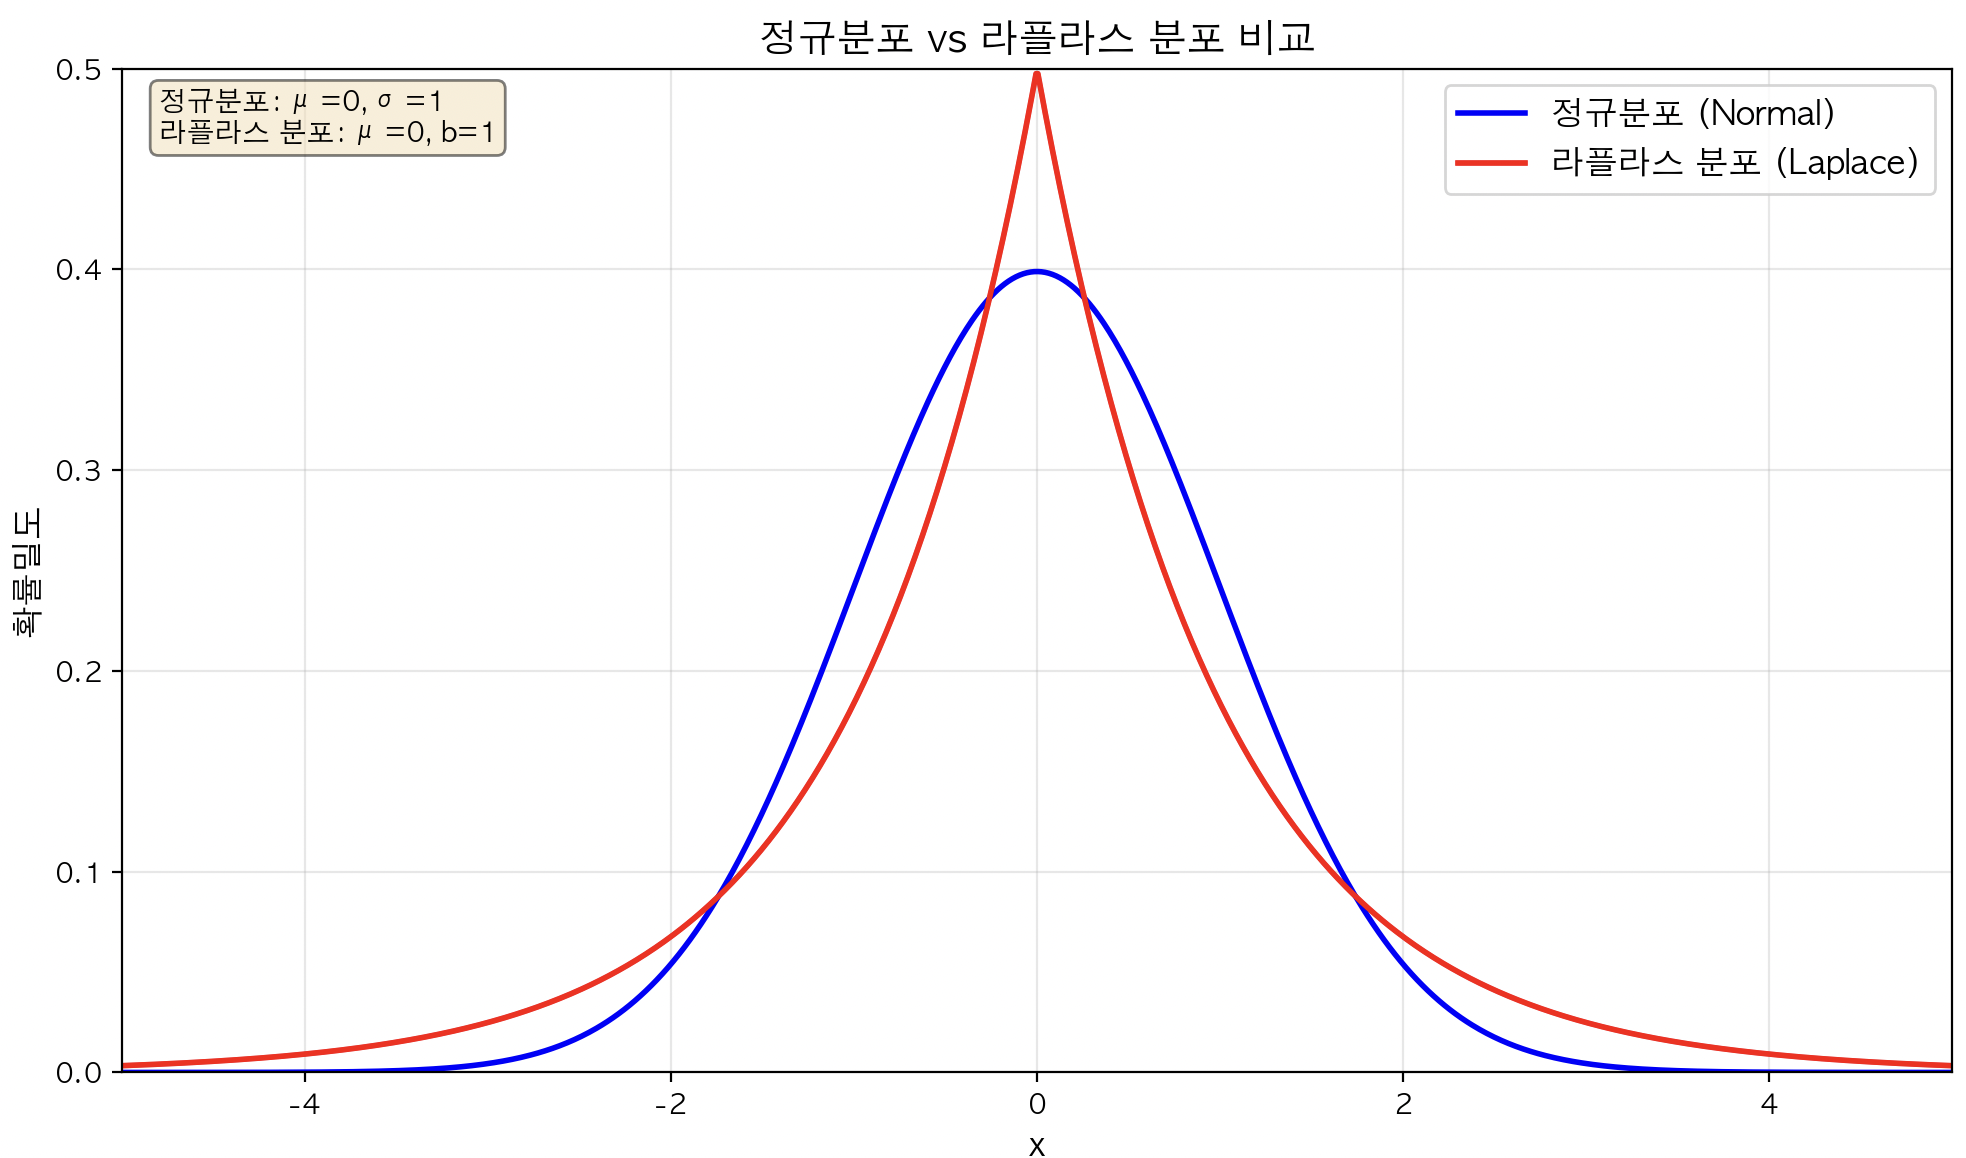

---

##### 1. 데이터의 음의 로그-우도($-\log P(\mathbf{y} | X)$) 작성 ✍️

선형 회귀 모델에서 $y = X\mathbf{w} + \epsilon$ 이고, 잡음 $\epsilon$은 지수 분포 $p(\epsilon) = \frac{1}{2}\exp(-|\epsilon|)$를 따른다고 가정합니다.
이는 각 데이터 포인트 $i$에 대해 $y_i = \mathbf{x}_i^\top \mathbf{w} + \epsilon_i$ 이고, 따라서 $\epsilon_i = y_i - \mathbf{x}_i^\top \mathbf{w}$ 임을 의미합니다.

각 $\epsilon_i$는 독립적으로 분포한다고 가정하므로, 관측값 $\mathbf{y}$가 주어질 우도(likelihood)는 각 $\epsilon_i$에 대한 확률 밀도 함수의 곱이 됩니다:
$P(\mathbf{y} | X, \mathbf{w}) = \prod_{i=1}^{n} p(\epsilon_i) = \prod_{i=1}^{n} \frac{1}{2} \exp(-|y_i - \mathbf{x}_i^\top \mathbf{w}|)$

이제 이 우도 함수의 음의 로그-우도(Negative Log-Likelihood, NLL)를 작성합니다:
$-\log P(\mathbf{y} | X, \mathbf{w}) = -\log \left( \prod_{i=1}^{n} \frac{1}{2} \exp(-|y_i - \mathbf{x}_i^\top \mathbf{w}|) \right)$
$= -\sum_{i=1}^{n} \log \left( \frac{1}{2} \exp(-|y_i - \mathbf{x}_i^\top \mathbf{w}|) \right)$
$= -\sum_{i=1}^{n} \left( \log\left(\frac{1}{2}\right) + \log\left(\exp(-|y_i - \mathbf{x}_i^\top \mathbf{w}|)\right) \right)$
$= -\sum_{i=1}^{n} \left( -\log(2) - |y_i - \mathbf{x}_i^\top \mathbf{w}| \right)$
$= \sum_{i=1}^{n} \left( \log(2) + |y_i - \mathbf{x}_i^\top \mathbf{w}| \right)$
$= n \log(2) + \sum_{i=1}^{n} |y_i - \mathbf{x}_i^\top \mathbf{w}|$

따라서, 데이터에 대한 음의 로그-우도는 **상수 항($n \log(2)$)과 잔차의 절대값 합($L_1$ 손실 또는 맨해튼 손실)**으로 구성됩니다.
$\text{NLL}(\mathbf{w}) = n \log(2) + \sum_{i=1}^{n} |y_i - \mathbf{x}_i^\top \mathbf{w}|$

---

##### 2. 닫힌 형태 해(Closed-Form Solution)를 찾을 수 있는가? 🕵️‍♀️

**아니요, 일반적으로 닫힌 형태 해를 찾을 수 없습니다.**

NLL 함수를 최소화하는 것은 $\sum_{i=1}^{n} |y_i - \mathbf{x}_i^\top \mathbf{w}|$를 최소화하는 것과 같습니다. 이는 **최소 절대 편차(Least Absolute Deviations, LAD)** 회귀 또는 **$L_1$ 회귀** 문제로 알려져 있습니다.

이 손실 함수는 각 $|y_i - \mathbf{x}_i^\top \mathbf{w}|$ 항이 $\mathbf{x}_i^\top \mathbf{w} = y_i$일 때 미분 불가능한 점(첨점)을 가집니다. 따라서 일반적인 선형 회귀에서 사용했던 것처럼 도함수를 0으로 놓고 해를 구하는 방식으로는 닫힌 형태의 해를 찾을 수 없습니다.

$L_1$ 손실을 최소화하는 문제는 선형 계획법(Linear Programming) 문제로 변환하여 해결할 수 있습니다. 예를 들어, 보조 변수를 도입하여 문제를 다음과 같이 재정의할 수 있습니다:
$\min \sum_{i=1}^{n} (s_i^+ + s_i^-)$
subject to $y_i - \mathbf{x}_i^\top \mathbf{w} = s_i^+ - s_i^-$
$s_i^+, s_i^- \ge 0$

이는 최적화 알고리즘(예: 심플렉스 방법)을 통해 풀 수 있지만, 닫힌 형태의 대수적 해는 아닙니다.

---

##### 3. 미니 배치 확률적 경사 하강법(Minibatch Stochastic Gradient Descent) 알고리즘 제안 및 문제점 ⚠️

###### 미니 배치 SGD 알고리즘 제안:

1.  **초기화:** 가중치 벡터 $\mathbf{w}$를 무작위로 초기화합니다. 학습률(learning rate) $\alpha$를 설정합니다.
2.  **반복:** 수렴할 때까지 다음 단계를 반복합니다.
    a.  **미니 배치 샘플링:** 훈련 데이터셋에서 무작위로 $B$개의 데이터 포인트(미니 배치)를 선택합니다. 이 미니 배치를 $(X_B, \mathbf{y}_B)$라고 합시다.
    b.  **경사 계산:** 미니 배치에 대한 손실 함수의 기울기를 계산합니다. 미니 배치에 대한 손실 함수는 $L_B(\mathbf{w}) = \sum_{(x_j, y_j) \in (X_B, \mathbf{y}_B)} |y_j - \mathbf{x}_j^\top \mathbf{w}|$ 입니다.
        $|u|$의 미분은 $u > 0$일 때 $1$, $u < 0$일 때 $-1$ 이고 $u = 0$일 때 미분 불가능합니다.
        따라서, $|y_j - \mathbf{x}_j^\top \mathbf{w}|$에 대한 $\mathbf{w}$의 기울기는 $-\mathbf{x}_j \cdot \text{sgn}(y_j - \mathbf{x}_j^\top \mathbf{w})$ 입니다. (여기서 $\text{sgn}$은 부호 함수)
        미니 배치에 대한 평균 기울기는 다음과 같습니다:
        $\nabla L_B(\mathbf{w}) = \frac{1}{B} \sum_{(x_j, y_j) \in (X_B, \mathbf{y}_B)} -\mathbf{x}_j \cdot \text{sgn}(y_j - \mathbf{x}_j^\top \mathbf{w})$
    c.  **파라미터 업데이트:** 계산된 기울기를 사용하여 $\mathbf{w}$를 업데이트합니다.
        $\mathbf{w} \leftarrow \mathbf{w} - \alpha \nabla L_B(\mathbf{w})$

###### 발생할 수 있는 문제점 (힌트: 정상점 근처에서 파라미터를 계속 업데이트하면 어떻게 되는가?) ⚠️

**문제점: 정상점 근처에서의 진동 (Oscillation) 및 불안정성.**

$L_1$ 손실 함수는 제곱 오차($L_2$ 손실)와 달리 부드럽지 않고, $\mathbf{x}_i^\top \mathbf{w} = y_i$ 인 지점마다 **첨점(sharp corner)**을 가집니다.
경사 하강법은 기울기를 따라 이동하는데, 첨점에서는 기울기가 불연속적으로 변합니다.

* **진동:** 특히 $\mathbf{w}$가 최적 해(정상점)에 가까워질 때, 잔차 $y_j - \mathbf{x}_j^\top \mathbf{w}$ 중 일부가 $0$에 가까워지거나 부호가 계속 바뀌는 상황이 발생할 수 있습니다. 이때 $\text{sgn}$ 함수의 출력($-1$ 또는 $1$)이 빠르게 뒤바뀌면서 기울기 방향이 급격히 변동합니다. 이는 $\mathbf{w}$가 최적점에서 안정적으로 정착하지 못하고 최적점 주변에서 **계속 진동(oscillate)하는 현상**을 초래할 수 있습니다. 큰 학습률은 이러한 진동을 더 심화시킬 수 있습니다.
* **수렴 실패:** 극단적인 경우, 최적점에 도달하지 못하고 특정 영역에서 맴돌거나 심지어 발산할 수도 있습니다.
* **미분 불가능성:** 최적 해가 되는 $\mathbf{w}$에서는 일부 $y_j - \mathbf{x}_j^\top \mathbf{w} = 0$이 되어 기울기가 정의되지 않을 수 있습니다. SGD는 이러한 경우에도 작동할 수 있지만, '정확한' 기울기를 얻을 수 없으므로 효율성이 떨어질 수 있습니다.

####### 해결 방안 ✅

이러한 문제를 해결하기 위한 몇 가지 방법이 있습니다:

1.  **점진적 학습률 감소 (Learning Rate Decay):** 📉
    학습률 $\alpha$를 시간이 지남에 따라 점진적으로 감소시킵니다. 초반에는 큰 학습률로 빠르게 최적점에 접근하고, 정상점에 가까워질수록 학습률을 작게 만들어 미세 조정을 통해 진동을 줄이고 안정적으로 수렴하도록 돕습니다.
    예: $\alpha_t = \frac{\alpha_0}{1 + kt}$ 또는 $\alpha_t = \alpha_0 \cdot \text{decay_rate}^t$.

2.  **적응적 학습률 방법 (Adaptive Learning Rate Methods):** ⚙️
    Adam, RMSprop, Adagrad와 같은 최적화 알고리즘은 각 파라미터에 대한 학습률을 동적으로 조정합니다. 이들은 기울기의 과거 정보(평균 제곱)를 사용하여 학습률을 조절함으로써, 기울기가 불연속적이거나 진동이 심한 경우에도 더 안정적인 수렴을 유도할 수 있습니다. 특히, Adam은 이러한 문제에 효과적일 수 있습니다.

3.  **서브그레이디언트(Subgradient)의 사용:** 📖
    미분 불가능한 지점에서는 서브그레이디언트 개념을 사용합니다. $|u|$의 서브그레이디언트는 $u>0$일 때 $\{1\}$, $u<0$일 때 $\{-1\}$, $u=0$일 때 $[-1, 1]$ 범위의 모든 값을 포함하는 집합입니다. SGD에서는 $u=0$일 때 임의의 값(예: $0$)을 선택하여 사용하거나, 부호 함수 $\text{sgn}(u)$가 $u=0$일 때 $0$을 반환하도록 정의하는 것이 일반적입니다.

4.  **근접 경사 방법 (Proximal Gradient Methods):** 🚶
    $L_1$ 정규화(라쏘)와 유사하게 $L_1$ 손실 함수를 최적화하는 데 특히 효과적인 전문화된 알고리즘입니다. 경사 하강 스텝과 $L_1$ 손실의 특성을 반영하는 근접 연산(proximal operator)을 결합하여 첨점 문제를 우회하면서 최적 해를 찾습니다. FISTA(Fast Iterative Shrinkage-Thresholding Algorithm)와 같은 알고리즘이 이에 해당합니다.

이러한 방법들을 통해 $L_1$ 손실 함수를 사용하는 선형 회귀 문제에서도 SGD 기반의 최적화가 가능하며, 정규 분포 잡음 모델($L_2$ 손실)에 비해 이상치에 더 강건한 모델을 얻을 수 있습니다. 🎯

6. Assume that we want to design a neural network with two layers by composing two linear layers. That is, the output of the first layer becomes the input of the second layer. Why would such a naive composition not work?

1. 두 개의 선형 층을 구성하여 두 개의 층을 가진 신경망을 설계한다고 가정해 보자.즉, 첫 번째 층의 출력이 두 번째 층의 입력이 된다.왜 이렇게 단순한 구성이 작동하지 않을까?


---
두 선형 계층을 합성하여 설계한 신경망은 비선형 함수를 학습할 수 없기 때문에 제대로 작동하지 않습니다. 🧠

---

##### 두 선형 계층의 합성

두 선형 계층을 합성한다는 것은 다음과 같습니다:

1.  **첫 번째 선형 계층:** 입력 벡터 $\mathbf{x}$를 받아 가중치 행렬 $W_1$과 편향 벡터 $\mathbf{b}_1$을 사용하여 출력을 생성합니다.
    $\mathbf{h} = W_1 \mathbf{x} + \mathbf{b}_1$
    여기서 $\mathbf{h}$는 첫 번째 계층의 출력(또는 은닉 상태)입니다.

2.  **두 번째 선형 계층:** 첫 번째 계층의 출력 $\mathbf{h}$를 입력으로 받아 가중치 행렬 $W_2$와 편향 벡터 $\mathbf{b}_2$를 사용하여 최종 출력을 생성합니다.
    $\mathbf{y} = W_2 \mathbf{h} + \mathbf{b}_2$

이제 이 두 식을 결합하여 $\mathbf{y}$를 $\mathbf{x}$에 대한 함수로 표현해 봅시다:
$\mathbf{y} = W_2 (W_1 \mathbf{x} + \mathbf{b}_1) + \mathbf{b}_2$
$\mathbf{y} = W_2 W_1 \mathbf{x} + W_2 \mathbf{b}_1 + \mathbf{b}_2$

이 식을 다시 정리하면 다음과 같습니다:
$\mathbf{y} = (W_2 W_1) \mathbf{x} + (W_2 \mathbf{b}_1 + \mathbf{b}_2)$

---

##### 왜 작동하지 않는가? 🚫

위의 최종 식을 보면, 두 선형 계층의 합성 결과는 여전히 **하나의 거대한 선형 변환**과 같습니다.

* $W_{\text{eff}} = W_2 W_1$: 이 두 행렬의 곱은 또 다른 **단일 행렬**입니다.
* $\mathbf{b}_{\text{eff}} = W_2 \mathbf{b}_1 + \mathbf{b}_2$: 이 두 벡터의 조합은 또 다른 **단일 편향 벡터**입니다.

따라서, $\mathbf{y} = W_{\text{eff}} \mathbf{x} + \mathbf{b}_{\text{eff}}$ 형태로 표현될 수 있으며, 이는 입력 $\mathbf{x}$에 대한 **단순한 선형 함수**에 불과합니다.

**문제점:**
신경망이 '깊이'를 가지는 주된 이유는 **비선형성**을 도입하여 복잡한 비선형 관계를 학습하기 위함입니다. 딥러닝의 핵심은 계층과 계층 사이에 ReLU(Rectified Linear Unit), 시그모이드(sigmoid), tanh와 같은 **비선형 활성화 함수(non-linear activation function)**를 삽입하는 것입니다. 이러한 비선형 활성화 함수가 없다면, 아무리 많은 선형 계층을 쌓아도 결국은 하나의 선형 계층으로 축소됩니다.

**비유:**
종이를 여러 번 접는다고 해서 종이의 면적이 갑자기 크게 늘어나지 않는 것과 비슷합니다. 비선형 활성화 함수는 종이를 단순히 접는 것을 넘어, 종이를 구기거나 자르거나 찢는 것과 같이 복잡한 변형을 가능하게 하여 훨씬 다양한 형태를 만들어낼 수 있게 합니다.

결론적으로, 선형 계층만으로 구성된 신경망은 단일 선형 계층과 동일한 표현력을 가지며, **선형적으로 분리 불가능한 문제(non-linearly separable problems)**를 해결할 수 없습니다. 이것이 바로 신경망 설계에서 각 계층 사이에 비선형 활성화 함수를 두는 이유입니다. 🔑

7. What happens if you want to use regression for realistic price estimation of houses or stock prices?
    1. Show that the additive Gaussian noise assumption is not appropriate. Hint: can we have negative prices? What about fluctuations?
    1. Why would regression to the logarithm of the price be much better, i.e., $y = \log \textrm{price}$?
    1. What do you need to worry about when dealing with pennystock, i.e., stock with very low prices? Hint: can you trade at all possible prices? Why is this a bigger problem for cheap stock? For more information review the celebrated Black--Scholes model for option pricing :cite:`Black.Scholes.1973`.

7. 주택이나 주가의 현실적인 가격 추정을 위해 회귀를 사용하려면 어떻게 해야 합니까?
   1. 가산 가우시안 잡음 가정이 적절하지 않음을 보여라.힌트: 음수 가격이 있을 수 있나요?가격 변동은 어떨까요?
   1. 가격의 로그로 회귀하는 것이 훨씬 더 나은 이유는 무엇인가요? 즉, $y = \log \textrm{price}$?
   1. 페니스톡(pennystock), 즉 매우 낮은 가격의 주식을 다룰 때 무엇을 고려해야 하나요?힌트: 가능한 모든 가격에서 거래할 수 있나요?저렴한 주식에서 이것이 더 큰 문제인 이유는 무엇인가요?더 자세한 내용은 유명한 옵션 가격 결정 모델인 Black-Scholes 모델을 참조하세요. :cite:`Black.Scholes.1973`.

---
현실적인 주택 가격이나 주식 가격을 예측하기 위해 회귀 분석을 사용할 때 발생하는 문제점과 해결책에 대해 설명해 드리겠습니다.

---

##### 1. 가산 가우스 잡음 가정의 부적절성 📉

**부정적 가격 불가능:**
가격은 본질적으로 **양수**여야 합니다. 주택 가격이나 주식 가격이 음수가 될 수는 없습니다. 가산 가우스 잡음(additive Gaussian noise) 모델 $y = X\mathbf{w} + \epsilon$에서 $\epsilon \sim N(0, \sigma^2)$는 잡음이 양수 또는 음수 값을 가질 수 있다고 가정합니다. 만약 예측값 $X\mathbf{w}$가 작고 $\epsilon$이 큰 음수 값을 가지게 되면, 결과적인 예측 가격 $y$가 음수가 될 수 있습니다. 이는 현실 세계의 가격 특성과 모순됩니다.

**변동폭의 불일치:**
가산 가우스 잡음은 잡음의 크기(변동폭)가 예측값의 크기와 무관하게 일정하다고 가정합니다. 즉, 100원짜리 주식에 대한 10원 변동과 100만 원짜리 주식에 대한 10원 변동이 동일한 중요도로 다루어집니다.
그러나 현실에서는 그렇지 않습니다.
* **주택 가격:** 1억 원짜리 주택의 1천만 원 변동은 매우 큰 변화지만, 100억 원짜리 주택의 1천만 원 변동은 상대적으로 작게 느껴집니다. 즉, **변동의 크기는 가격 수준에 비례**하는 경향이 있습니다.
* **주식 가격:** 1,000원짜리 주식이 100원 오르는 것(10% 상승)과 100,000원짜리 주식이 100원 오르는 것(0.1% 상승)은 투자자에게 주는 의미가 다릅니다. 주식 시장에서는 **퍼센트 변동률**이 절대적인 가격 변동보다 더 중요하게 여겨집니다.
가산 잡음 모델은 이러한 상대적 변동성 패턴을 제대로 포착할 수 없습니다.

---

##### 2. 가격의 로그에 대해 회귀 분석을 수행하는 것이 더 나은 이유 📈

$y = \log(\text{price})$로 회귀 분석을 수행하는 것이 훨씬 더 나은 이유는 다음과 같습니다.

**음수 가격 회피:**
가격 $P$에 대해 로그를 취하면 $\log(P)$는 양수, 음수 또는 0의 값을 가질 수 있습니다. 그리고 나중에 예측된 $\log(P)$ 값에 지수 함수를 취하여 실제 가격을 역변환할 때, $P = \exp(\log(P))$는 항상 양수 값을 가집니다. 이는 가격이 음수가 될 수 없다는 현실적인 제약을 만족시킵니다.

**상대적 변동성 모델링:**
로그 변환은 **승법 잡음(multiplicative noise)** 모델을 가산 잡음 모델로 변환하는 효과가 있습니다.
원래 가격 모델을 다음과 같이 가정해 봅시다:
$\text{price} = \exp(X\mathbf{w} + \epsilon)$
또는 잡음이 곱해지는 형태로:
$\text{price} = \text{base_price} \cdot \exp(\epsilon')$
이 경우 양변에 로그를 취하면:
$\log(\text{price}) = \log(\text{base_price}) + \epsilon'$
여기서 $\log(\text{base_price})$는 $X\mathbf{w}$와 같고, $\epsilon'$는 정규 분포를 따른다고 가정할 수 있습니다. 즉, 로그 변환은 상대적인(퍼센트) 변동이 정규 분포를 따른다고 가정하는 것과 유사합니다. 이는 가격 수준이 높을수록 변동폭도 커지는 현실적인 현상을 잘 반영합니다.

**왜곡된 분포 완화:**
주택 가격이나 주식 가격과 같은 많은 금융 데이터는 종종 **오른쪽으로 치우친(right-skewed)** 분포를 보입니다 (즉, 소수의 매우 높은 가격과 다수의 낮은 가격). 로그 변환은 이러한 왜곡된 분포를 대칭에 가깝게 만들거나 정규 분포와 유사한 형태로 변환하여, 선형 회귀의 정규성 가정을 더 잘 만족시킬 수 있습니다.

**블랙-숄즈 모델과의 연관성:**
옵션 가격을 책정하는 데 사용되는 유명한 **블랙-숄즈 모델(Black-Scholes model)**은 기초 자산의 가격이 **기하 브라운 운동(Geometric Brownian Motion)**을 따른다고 가정합니다. 이는 자산 가격의 로그가 브라운 운동(즉, 정규 분포를 따르는 증분)을 따른다는 것을 의미합니다. 즉, 가격의 변동률이 정규 분포를 따른다고 보는 것입니다. 이러한 통찰은 금융 모델링에서 로그 변환이 매우 자연스럽고 강력한 선택임을 뒷받침합니다.

---

##### 3. 페니스탁(Penny Stock)을 다룰 때의 문제점 💲

페니스탁(penny stock)은 가격이 매우 낮은 주식(보통 주당 5달러 미만)을 의미합니다. 이러한 주식을 다룰 때 로그 변환 회귀에서 다음과 같은 문제가 발생할 수 있습니다.

**가격 호가 단위의 제약 (디지털화 효과):**
* **모든 가능한 가격으로 거래될 수 있는가? 아니요.** 주식 시장에서는 가격이 최소 호가 단위로 거래됩니다. 예를 들어, 100원짜리 주식은 101원, 102원으로 움직이지, 100.1원, 100.01원과 같이 연속적인 값으로 움직이지 않습니다. 한국 주식 시장의 경우, 1,000원 미만 주식은 1원 단위, 1,000원 이상 5,000원 미만은 5원 단위 등으로 호가 단위가 정해져 있습니다.
* **왜 저가 주식에 더 큰 문제인가?**
    * **상대적 변동폭의 불연속성:** 100원짜리 주식이 1원 오르면 1% 상승입니다. 1원이 최소 호가 단위라면, 이 주식의 최소 가격 변동률은 1%입니다. 이는 $\log(101/100) \approx 0.00995$ 만큼의 로그 가격 변화를 의미합니다.
    * 반면 10,000원짜리 주식은 5원 단위로 움직일 수 있고, 5원 상승은 0.05% 상승입니다.
    * 즉, 저가 주식의 경우 **로그 가격의 최소 변화폭 자체가 상대적으로 훨씬 크고 불연속적**입니다. 모델이 예측한 미세한 로그 가격 변화가 실제 시장에서 불가능한 경우가 많아집니다. 예를 들어, 모델이 100.5원이라고 예측하더라도 실제로는 100원 또는 101원으로만 거래될 수 있습니다.
    * 이는 모델이 예측하는 **연속적인 로그 가격 공간**과 **실제 시장의 이산적인 호가 공간** 사이의 불일치를 크게 만듭니다. 고가 주식의 경우 최소 호가 단위가 전체 가격에서 차지하는 비율이 작기 때문에 이러한 이산성 문제가 덜 두드러집니다.

**유동성 문제 및 비정규적 행태:**
페니스탁은 종종 유동성이 매우 낮고, 투기적인 경향이 강하며, 시장 조작에 취약할 수 있습니다. 이러한 요인들은 가격 변동이 '정규적인' 통계적 속성을 따르지 않을 수 있음을 의미합니다. 로그 변환이 일반적으로 정규 분포를 가정하는 모델에 적합하게 데이터를 변환하지만, 페니스탁의 극단적인 특성은 이러한 가정을 약화시킬 수 있습니다.

요약하자면, 가격 예측을 위해 회귀 분석을 사용할 때 로그 변환은 음수 가격 문제를 해결하고 상대적 변동성을 더 잘 모델링하는 강력한 도구입니다. 하지만 페니스탁과 같이 가격이 매우 낮은 자산의 경우, 시장의 최소 호가 단위로 인한 이산성 문제가 로그 변환된 모델의 정확성과 유용성을 저해할 수 있다는 점을 고려해야 합니다.

8. Suppose we want to use regression to estimate the *number* of apples sold in a grocery store.
    1. What are the problems with a Gaussian additive noise model? Hint: you are selling apples, not oil.
    1. The [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) captures distributions over counts. It is given by $p(k \mid \lambda) = \lambda^k e^{-\lambda}/k!$. Here $\lambda$ is the rate function and $k$ is the number of events you see. Prove that $\lambda$ is the expected value of counts $k$.
    1. Design a loss function associated with the Poisson distribution.
    1. Design a loss function for estimating $\log \lambda$ instead.


7. 회귀를 사용하여 식료품점에서 판매되는 사과의 *개수*를 추정한다고 가정해 보겠습니다.
   1. 가우시안 가산 잡음 모델의 문제점은 무엇인가요?힌트: 당신은 기름이 아니라 사과를 판매하고 있습니다.
   1. [푸아송 분포](https://en.wikipedia.org/wiki/Poisson_distribution)는 개수에 따른 분포를 포착합니다.$p(k \mid \lambda) = \lambda^k e^{-\lambda}/k!$로 주어집니다.여기서 $\lambda$는 속도 함수이고 $k$는 보이는 사건의 개수입니다.$\lamda$가 개수 $k$의 기댓값임을 증명하세요.
   1. 포아송 분포와 관련된 손실 함수를 설계하세요.
   1. 대신 $\log \lambda$를 추정하는 손실 함수를 설계하세요.


여기 질문에 대한 답변입니다.

##### 1. 가우스 가산 잡음 모델의 문제점 🍎

식료품점에서 판매된 사과 수량을 추정할 때 가우스 가산 잡음(Gaussian additive noise) 모델 ($y = X\mathbf{w} + \epsilon$, $\epsilon \sim N(0, \sigma^2)$)은 다음과 같은 문제점이 있습니다.

* **음수 개수 불가능:** 사과 판매량은 항상 0개 이상의 정수여야 합니다. 가우스 잡음은 음수 값을 가질 수 있기 때문에, 예측된 판매량이 음수가 나올 가능성이 있습니다. 이는 현실 세계의 개수 개념과 모순됩니다. 사과는 '개수'로 세는 이산적인 항목이지, '양'으로 측정하는 연속적인 기름과 다릅니다.

* **정수 값 불일치:** 가우스 잡음 모델은 연속적인 값을 예측하지만, 사과 판매량은 1개, 2개와 같이 이산적인 정수 값이어야 합니다. 모델이 10.5개의 사과를 예측한다면, 이를 실제 판매량으로 해석하기 어렵습니다.

* **변동폭의 부적절성:** 판매량이 적을 때는 변동폭도 작고, 판매량이 많을 때는 변동폭도 커지는 경향이 있습니다. 가우스 가산 잡음은 판매량의 크기와 무관하게 일정한 변동폭을 가정하므로, 이러한 관계를 제대로 반영하지 못합니다. 예를 들어, 하루에 사과를 5개 파는 가게에서 2개 변동은 매우 크지만, 500개 파는 가게에서 2개 변동은 미미합니다. 즉, 변동의 크기가 평균 판매량에 비례하는 경우가 많습니다.

---

##### 2. 푸아송 분포에서 $\lambda$가 기대값임을 증명 📚

푸아송 분포의 확률 질량 함수(PMF)는 다음과 같습니다:
$p(k | \lambda) = \frac{\lambda^k e^{-\lambda}}{k!}$
여기서 $k$는 사건의 횟수($0, 1, 2, \ldots$), $\lambda$는 단위 시간 또는 단위 공간에서 평균적으로 발생하는 사건의 횟수를 나타내는 비율 매개변수($\lambda > 0$)입니다.

푸아송 분포에서 $k$의 기대값 $E[k]$는 다음과 같이 정의됩니다:
$E[k] = \sum_{k=0}^{\infty} k \cdot p(k | \lambda) = \sum_{k=0}^{\infty} k \frac{\lambda^k e^{-\lambda}}{k!}$

$k=0$일 때 항은 $0 \cdot p(0|\lambda) = 0$이므로, 합은 $k=1$부터 시작할 수 있습니다:
$E[k] = \sum_{k=1}^{\infty} k \frac{\lambda^k e^{-\lambda}}{k!}$

$k! = k \cdot (k-1)!$ 이므로, $k$를 약분할 수 있습니다:
$E[k] = \sum_{k=1}^{\infty} \frac{\lambda^k e^{-\lambda}}{(k-1)!}$

이제 $\lambda e^{-\lambda}$를 합 밖으로 빼낼 수 있습니다:
$E[k] = \lambda e^{-\lambda} \sum_{k=1}^{\infty} \frac{\lambda^{k-1}}{(k-1)!}$

새로운 변수 $j = k-1$로 치환합시다. $k=1$일 때 $j=0$이 되고, $k \to \infty$일 때 $j \to \infty$가 됩니다:
$E[k] = \lambda e^{-\lambda} \sum_{j=0}^{\infty} \frac{\lambda^{j}}{j!}$

테일러 급수 전개에 따르면, $e^x = \sum_{j=0}^{\infty} \frac{x^j}{j!}$ 입니다. 따라서 $\sum_{j=0}^{\infty} \frac{\lambda^{j}}{j!} = e^{\lambda}$ 입니다.

이것을 다시 기대값 식에 대입하면:
$E[k] = \lambda e^{-\lambda} \cdot e^{\lambda}$
$E[k] = \lambda$

따라서, 푸아송 분포에서 매개변수 $\lambda$는 실제로 **기대값($E[k]$)이자 분산($\text{Var}[k]$) **입니다.

---

##### 3. 푸아송 분포와 관련된 손실 함수 설계 📏

푸아송 분포에 기반한 회귀 모델에서 손실 함수는 보통 **음의 로그-우도(Negative Log-Likelihood, NLL)** 함수로 정의됩니다.

주어진 데이터셋 $(x_i, y_i)$ ($i=1, \ldots, N$)에서 $y_i$는 관측된 사과 판매량(카운트)이고, $x_i$는 예측에 사용되는 특성 벡터입니다. 우리는 $y_i$가 푸아송 분포를 따르며, 그 매개변수 $\lambda_i$가 $x_i$와 회귀 모델의 가중치 $\mathbf{w}$에 의해 결정된다고 가정합니다.

가장 단순한 가정은 $\lambda_i = \mathbf{x}_i^\top \mathbf{w}$와 같이 선형 모델을 사용하는 것입니다. 하지만 $\lambda$는 양수여야 하므로, $\lambda_i = \exp(\mathbf{x}_i^\top \mathbf{w})$ 와 같이 양수 값을 보장하는 활성화 함수를 사용하는 것이 일반적입니다. 여기서는 $\lambda_i$를 예측하는 일반적인 형태로 둡니다.

데이터의 우도 함수는 다음과 같습니다:
$P(\mathbf{y} | X, \mathbf{w}) = \prod_{i=1}^{N} p(y_i | \lambda_i(\mathbf{x}_i, \mathbf{w})) = \prod_{i=1}^{N} \frac{\lambda_i^{y_i} e^{-\lambda_i}}{y_i!}$

음의 로그-우도(NLL)는 다음과 같습니다:
$L(\mathbf{w}) = -\log P(\mathbf{y} | X, \mathbf{w})$
$L(\mathbf{w}) = -\sum_{i=1}^{N} \log \left( \frac{\lambda_i^{y_i} e^{-\lambda_i}}{y_i!} \right)$
$L(\mathbf{w}) = -\sum_{i=1}^{N} (y_i \log(\lambda_i) - \lambda_i - \log(y_i!))$
$L(\mathbf{w}) = \sum_{i=1}^{N} (\lambda_i - y_i \log(\lambda_i) + \log(y_i!))$

여기서 $\log(y_i!)$ 항은 $\mathbf{w}$에 의존하지 않으므로, 최적화 과정에서는 상수로 취급되어 무시할 수 있습니다. 따라서, 최적화에 사용되는 실제 손실 함수는 다음과 같습니다:

**푸아송 손실 함수 (Poisson Loss Function):**
$L(\mathbf{w}) = \sum_{i=1}^{N} (\lambda_i - y_i \log(\lambda_i))$

이 손실 함수는 **상대 엔트로피(relative entropy)** 또는 **쿨백-라이블러 발산(Kullback-Leibler divergence)**의 특별한 경우로, 예측된 푸아송 분포가 실제 관측된 카운트의 분포를 얼마나 잘 근사하는지를 측정합니다.

---

##### 4. $\log \lambda$를 추정하기 위한 손실 함수 설계 📐

만약 우리가 직접 $\lambda$를 추정하는 대신 $\log \lambda$를 추정하는 모델을 만든다면, 즉 $\log \lambda_i = \mathbf{x}_i^\top \mathbf{w}$ (또는 더 일반적인 신경망의 출력)이라고 가정한다면, 손실 함수는 어떻게 될까요?

이 경우 모델의 출력은 $\eta_i = \mathbf{x}_i^\top \mathbf{w}$ (연결 함수, link function)가 되며, 실제 $\lambda_i$는 $\lambda_i = \exp(\eta_i)$ 관계를 가집니다. 이를 **로그-선형 모델(log-linear model)**이라고 합니다.

3번에서 도출한 푸아송 손실 함수에 $\lambda_i = \exp(\eta_i)$를 대입합니다:
$L(\mathbf{w}) = \sum_{i=1}^{N} (\lambda_i - y_i \log(\lambda_i))$

$\lambda_i = \exp(\eta_i)$ 이므로, $\log(\lambda_i) = \eta_i$ 입니다.
이들을 대입하면:

**로그 $\lambda$를 추정하기 위한 푸아송 손실 함수:**
$L(\mathbf{w}) = \sum_{i=1}^{N} (\exp(\eta_i) - y_i \eta_i)$
$L(\mathbf{w}) = \sum_{i=1}^{N} (\exp(\mathbf{x}_i^\top \mathbf{w}) - y_i \mathbf{x}_i^\top \mathbf{w})$

이 손실 함수를 최소화함으로써, $\mathbf{w}$는 관측된 카운트 $y_i$를 가장 잘 설명하는 $\log \lambda_i$ 값을 예측하게 됩니다. 이 접근 방식은 $\lambda$가 항상 양수 값을 보장하므로, 음수 예측 문제를 자동으로 해결하며 푸아송 회귀(Poisson Regression)에서 표준적으로 사용됩니다.

[Discussions](https://discuss.d2l.ai/t/258)

[토론](https://discuss.d2l.ai/t/258)
